# 数据预处理

## 导入数据

In [23]:
# 导入相关package
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import chardet

In [24]:
import os

# 设置环境变量 LOKY_MAX_CPU_COUNT
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # 使用CPU 核心数

In [25]:
# 定义一个函数，自动检测文件编码并读取文件
def read_csv_with_detected_encoding(file_path):
    # 检测文件编码
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
        print(f"检测到文件 {file_path} 的编码格式为：{encoding}")
    # 使用检测到的编码读取文件
    return pd.read_csv(file_path, encoding=encoding)

# 读取 data_dictionary.csv 文件
csv_content = read_csv_with_detected_encoding('2025_Problem_C_Data\\data_dictionary.csv')
print("data_dictionary.csv 数据预览：")
print(csv_content.head())

# 读取 summerOly_medal_counts.csv 文件
medal_counts = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_medal_counts.csv')
print("\nsummerOly_medal_counts.csv 数据预览：")
print(medal_counts.head())

# 读取 summerOly_hosts.csv 文件
olympic_hosts = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_hosts.csv')
print("\nsummerOly_hosts.csv 数据预览：")
print(olympic_hosts.head())

# 读取 summerOly_programs.csv 文件
olympic_programs = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_programs.csv')
print("\nsummerOly_programs.csv 数据预览：")
print(olympic_programs.head())

# 读取 summerOly_athletes.csv 文件
olympic_athletes = read_csv_with_detected_encoding('2025_Problem_C_Data\\summerOly_athletes.csv')
print("\nsummerOly_athletes.csv 数据预览：")
print(olympic_athletes.head())

检测到文件 2025_Problem_C_Data\data_dictionary.csv 的编码格式为：Windows-1252
data_dictionary.csv 数据预览：
  summerOly_medal_counts.csv                                     Unnamed: 1  \
0                  variables                                    explanation   
1                       Rank      Rank of country based on total medals won   
2                        NOC  Name of country as recorded for that Olympics   
3                       Gold       Number of Gold medals the country earned   
4                     Silver     Number of Silver medals the country earned   

      Unnamed: 2  
0        example  
1           1, 2  
2  China, France  
3        0, 1, 2  
4        0, 1, 2  
检测到文件 2025_Problem_C_Data\summerOly_medal_counts.csv 的编码格式为：utf-8

summerOly_medal_counts.csv 数据预览：
   Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896
2     3        Germany     6       5       2 

## 数据清洗

### 缺失值检查

In [26]:
# 1. 缺失值检查
def check_missing_values(file_path):
    """
    检查 CSV 文件中的缺失值。

    参数:
        file_path (str): CSV 文件的路径。

    返回:
        None，但会打印缺失值的相关信息。
    """
    try:
        # 尝试读取 CSV 文件
        data = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        data = pd.read_csv(file_path, encoding='ISO-8859-1')

    print(file_path)

    # 检查每列的缺失值数量
    missing_values_per_column = data.isnull().sum()
    print("每列的缺失值数量：")
    print(missing_values_per_column)

    # 检查整个数据框的总缺失值数量
    total_missing_values = missing_values_per_column.sum()
    print("整个数据框的总缺失值数量：", total_missing_values)

    # 检查是否有任何缺失值
    has_missing_values = data.isnull().values.any()
    print("数据框中是否存在缺失值：", has_missing_values)
    print("\n")

    # 如果有缺失值，输出包含缺失值的行
    if has_missing_values:
        print("\n包含缺失值的行：")
        print(data[data.isnull().any(axis=1)])
    
content_name = ['2025_Problem_C_Data\\summerOly_medal_counts.csv', '2025_Problem_C_Data\\summerOly_hosts.csv', '2025_Problem_C_Data\\summerOly_programs.csv', '2025_Problem_C_Data\\summerOly_athletes.csv']
for i in content_name:
    check_missing_values(i)

2025_Problem_C_Data\summerOly_medal_counts.csv
每列的缺失值数量：
Rank      0
NOC       0
Gold      0
Silver    0
Bronze    0
Total     0
Year      0
dtype: int64
整个数据框的总缺失值数量： 0
数据框中是否存在缺失值： False


2025_Problem_C_Data\summerOly_hosts.csv
每列的缺失值数量：
Year    0
Host    0
dtype: int64
整个数据框的总缺失值数量： 0
数据框中是否存在缺失值： False


2025_Problem_C_Data\summerOly_programs.csv
每列的缺失值数量：
Sport                    0
Discipline               2
Code                     0
Sports Governing Body    0
1896                     0
1900                     0
1904                     0
1906*                    0
1908                     0
1912                     0
1920                     0
1924                     0
1928                     2
1932                     2
1936                     2
1948                     2
1952                     2
1956                     2
1960                     2
1964                     2
1968                     2
1972                     2
1976                     2
1980           

### 补全summerOly_programs.csv中的缺失值

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import re
import os

# 确保保存结果的目录存在
os.makedirs('Generated', exist_ok=True)

data = olympic_programs.copy()

# 3. 检查缺失值
#print("每列的缺失值数量：")
#print(data.isnull().sum())

# 4. 填充 Discipline 列的缺失值
data['Discipline'] = data['Discipline'].fillna(data['Sport'])

# 5. 准备年份列的数据
years = [col for col in data.columns if col.isdigit() or col.endswith('*')]

# 6. 将数据从宽格式转换为长格式
data_long = data.melt(id_vars=['Sport', 'Discipline', 'Code', 'Sports Governing Body'], 
                      value_vars=years, 
                      var_name='Year', 
                      value_name='Events')

# 7. 将年份列转换为数值
data_long['Year'] = data_long['Year'].str.replace('*', '').astype(int)

# 8. 清理 Events 列中的非数值字符
def clean_events(value):
    if isinstance(value, str):
        # 移除非数值字符
        cleaned_value = re.sub(r'[^0-9]', '', value)
        return float(cleaned_value) if cleaned_value.isdigit() else np.nan
    return value

data_long['Events'] = data_long['Events'].apply(clean_events)

# 9. 将1924年以及之后的 Skating 和 Ice Hockey 项目的赛事数目填为0
mask = (data_long['Year'] >= 1924) & (data_long['Sport'].isin(['Skating', 'Ice Hockey']))
data_long.loc[mask, 'Events'] = 0

# 10. 分组处理，按运动种类单独训练模型
for sport, group in data_long.groupby('Sport'):
    # 分离已知数据和缺失数据
    known_data = group.dropna(subset=['Events'])
    missing_data = group[group['Events'].isna()]
    
    if not known_data.empty and not missing_data.empty:
        # 准备训练数据
        X_known = known_data[['Year']]
        y_known = known_data['Events']
        
        # 检查已知数据的数量
        if len(y_known) < 5:
            print(f"警告：运动种类 '{sport}' 的已知数据太少，使用 KNN 或线性回归填充。")
            
            # 尝试使用线性回归
            if len(y_known) >= 3:  # 至少需要3个点来拟合线性回归
                model = LinearRegression()
                model.fit(X_known, y_known)
                predicted_events = model.predict(missing_data[['Year']])
            else:  # 使用 KNN，K=1
                model = KNeighborsRegressor(n_neighbors=1)
                model.fit(X_known, y_known)
                predicted_events = model.predict(missing_data[['Year']])
            
            # 将预测值四舍五入为整数
            predicted_events = np.round(predicted_events).astype(int)
            
            # 将预测值转换为 Pandas Series，并确保索引对齐
            predicted_series = pd.Series(predicted_events, index=missing_data.index)
            
            # 填充缺失值
            data_long.loc[data_long['Sport'] == sport, 'Events'] = data_long.loc[data_long['Sport'] == sport, 'Events'].fillna(predicted_series)
        else:
            # 训练随机森林模型
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_known, y_known)
            
            # 预测缺失数据
            X_missing = missing_data[['Year']]
            predicted_events = model.predict(X_missing)
            
            # 将预测值四舍五入为整数
            predicted_events = np.round(predicted_events).astype(int)
            
            # 将预测值转换为 Pandas Series，并确保索引对齐
            predicted_series = pd.Series(predicted_events, index=missing_data.index)
            
            # 填充缺失值
            data_long.loc[data_long['Sport'] == sport, 'Events'] = data_long.loc[data_long['Sport'] == sport, 'Events'].fillna(predicted_series)
            
            # 记录日志
            print(f"运动种类 '{sport}' 的模型训练完成，预测了 {len(predicted_events)} 个缺失值。")
    else:
        print(f"运动种类 '{sport}' 没有缺失数据或没有足够的已知数据。")

# 11. 将数据重新转换为宽格式
data_filled = data_long.pivot_table(index=['Sport', 'Discipline', 'Code', 'Sports Governing Body'], 
                                    columns='Year', 
                                    values='Events', 
                                    aggfunc='first').reset_index()

# 12. 输出结果
print("\n填充后的数据：")
print(data_filled.head())

# 13. 保存结果到新的 CSV 文件
output_path = 'Generated\\summerOly_programs_filled.csv'
data_filled.to_csv(output_path, index=False, encoding='utf-8')  # 确保保存时使用正确的编码
print(f"填充后的数据已保存到 {output_path}")

运动种类 'Aquatics' 没有缺失数据或没有足够的已知数据。
运动种类 'Archery' 没有缺失数据或没有足够的已知数据。
运动种类 'Athletics' 没有缺失数据或没有足够的已知数据。
运动种类 'Badminton' 的模型训练完成，预测了 2 个缺失值。
运动种类 'Baseball and Softball' 的模型训练完成，预测了 8 个缺失值。
运动种类 'Basketball' 的模型训练完成，预测了 2 个缺失值。
运动种类 'Basque Pelota' 的模型训练完成，预测了 4 个缺失值。
运动种类 'Boxing' 没有缺失数据或没有足够的已知数据。
运动种类 'Breaking' 没有缺失数据或没有足够的已知数据。
运动种类 'Canoeing' 的模型训练完成，预测了 1 个缺失值。
运动种类 'Cricket' 没有缺失数据或没有足够的已知数据。
运动种类 'Croquet' 没有缺失数据或没有足够的已知数据。
运动种类 'Cycling' 没有缺失数据或没有足够的已知数据。
运动种类 'Equestrian' 没有缺失数据或没有足够的已知数据。
运动种类 'Fencing' 没有缺失数据或没有足够的已知数据。
运动种类 'Field hockey' 没有缺失数据或没有足够的已知数据。
运动种类 'Flag football' 没有缺失数据或没有足够的已知数据。
运动种类 'Football' 没有缺失数据或没有足够的已知数据。
运动种类 'Golf' 没有缺失数据或没有足够的已知数据。
运动种类 'Gymnastics' 没有缺失数据或没有足够的已知数据。
运动种类 'Handball' 的模型训练完成，预测了 1 个缺失值。
运动种类 'Ice Hockey' 没有缺失数据或没有足够的已知数据。
运动种类 'Jeu de Paume' 没有缺失数据或没有足够的已知数据。
运动种类 'Judo' 没有缺失数据或没有足够的已知数据。
运动种类 'Karate' 没有缺失数据或没有足够的已知数据。
运动种类 'Lacrosse' 的模型训练完成，预测了 3 个缺失值。
运动种类 'Modern Pentathlon' 没有缺失数据或没有足够的已知数据。
运动种类 'Polo' 没有缺失数据或没有足够的已知数据。
运动种类 

### Medal_counts 数据清洗

In [28]:
# 2. 数据清洗
# 确保数据的格式正确
data = medal_counts[['Year', 'NOC', 'Gold', 'Silver', 'Bronze', 'Total']]

# 3. 创建年份和国家的索引
years = data['Year'].unique()
noc = data['NOC'].unique()

# 4. 定义一个函数来生成表格
def generate_table(data, column_name):
    # 创建一个空的 DataFrame，以年份为列，国家为行
    table = pd.DataFrame(index=noc, columns=years)
    
    # 填充数据
    for index, row in data.iterrows():
        year = row['Year']
        country = row['NOC']
        value = row[column_name]
        table.at[country, year] = value
    
    # 推断数据类型并填充缺失值为0
    table = table.infer_objects(copy=False).fillna(0).astype(int)
    
    return table

# 5. 生成金牌、银牌、铜牌和总数的表格
gold_table = generate_table(data, 'Gold')
silver_table = generate_table(data, 'Silver')
bronze_table = generate_table(data, 'Bronze')
total_table = generate_table(data, 'Total')

# 6. 保存到新的 CSV 文件
gold_table.to_csv('Generated\\summerOly_gold_summary.csv')
silver_table.to_csv('Generated\\summerOly_silver_summary.csv')
bronze_table.to_csv('Generated\\summerOly_bronze_summary.csv')
total_table.to_csv('Generated\\summerOly_total_summary.csv')

In [29]:
# 7. 输出结果
print("金牌表格：")
print(gold_table)

金牌表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States           11    19    76    23    26    41    45    22     0   
Greece                  10     0     1     0     1     0     0     0     0   
Germany                  6     4     4     3     5     0     0    10     0   
France                   5    27     0     5     7     9    13     6     0   
Great Britain            2    15     1    56    10    14     9     3     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000  

In [30]:
print("\n银牌表格：")
print(silver_table)


银牌表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States            7    14    78    12    19    27    27    18     0   
Greece                  18     0     0     3     0     1     0     0     0   
Germany                  5     3     5     5    13     0     0     7     0   
France                   4    39     1     5     4    19    15    10     0   
Great Britain            3     7     1    51    15    15    13    10     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000 

In [31]:
print("\n铜牌表格：")
print(bronze_table)


铜牌表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States            2    15    77    12    19    27    27    16     0   
Greece                  19     0     1     1     1     0     0     0     0   
Germany                  2     2     6     5     7     0     0    14     0   
France                   2    37     0     9     3    13    10     5     0   
Great Britain            2     9     0    39    16    13    12     7     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000 

In [32]:

print("\n总数表格：")
print(total_table)


总数表格：
                      1896  1900  1904  1908  1912  1920  1924  1928  1932  \
United States           20    48   231    47    64    95    99    56     0   
Greece                  47     0     2     4     2     1     0     0     0   
Germany                 13     9    15    13    25     0     0    31     0   
France                  11   103     1    19    14    41    38    21     0   
Great Britain            7    31     2   146    41    42    34    20     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Saint Lucia              0     0     0     0     0     0     0     0     0   
Dominica                 0     0     0     0     0     0     0     0     0   
Albania                  0     0     0     0     0     0     0     0     0   
Cabo Verde               0     0     0     0     0     0     0     0     0   
Refugee Olympic Team     0     0     0     0     0     0     0     0     0   

                      1936  ...  1988  1992  1996  2000 

### 清理summerOly_medal_counts.csv异常值

In [33]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# 读取CSV文件
file_path = '2025_Problem_C_Data\\summerOly_medal_counts.csv'
data = pd.read_csv(file_path)

# 定义一个函数，用于剔除非英文字符
def remove_non_english_chars(text):
    if pd.isnull(text):
        return text
    return re.sub(r'[^a-zA-Z]', '', text)

# 对NOC列进行数据检查和处理
data['NOC'] = data['NOC'].apply(remove_non_english_chars)

# 提取实际的奥运会年份
olympic_years = data['Year'].unique()
olympic_years = np.sort(olympic_years)  # 按年份排序
print("实际的奥运会年份：", olympic_years)

# 将数据按年份和国家分组
data['Year'] = data['Year'].astype(int)
data['NOC'] = data['NOC'].astype(str)
data = data[['Year', 'NOC', 'Gold', 'Silver', 'Bronze', 'Total']]

# 获取所有国家
countries = data['NOC'].unique()

# 创建一个完整的年份和国家组合的DataFrame
all_combinations = pd.MultiIndex.from_product([olympic_years, countries], names=['Year', 'NOC']).to_frame(index=False)

# 合并数据，填充缺失值为NaN（暂时不填充为0）
complete_data = pd.merge(all_combinations, data, on=['Year', 'NOC'], how='left')

# 计算每个国家首次参加奥运会的时间
first_participation = complete_data[complete_data['Total'] > 0].groupby('NOC')['Year'].min().reset_index()
first_participation.columns = ['NOC', 'First_Participation']
complete_data = pd.merge(complete_data, first_participation, on='NOC', how='left')

# 将每个国家在首次参加之前的所有年份的奖牌数填充为0
complete_data.loc[complete_data['Year'] < complete_data['First_Participation'], ['Gold', 'Silver', 'Bronze', 'Total']] = 0

# 将首次参加时间列删除，因为它已经不再需要
complete_data.drop(columns=['First_Participation'], inplace=True)

# 定义一个函数来处理每个奖牌类型
def knn_impute(column_name):
    # 提取需要处理的列
    grouped = complete_data[['Year', 'NOC', column_name]].groupby('NOC')
    # 将分组结果转换为多个 DataFrame
    grouped_dfs = [group for noc, group in grouped]
    for df in grouped_dfs:
        current_noc = df['NOC'].iloc[0]  # 由于每个分组的 'NOC' 是相同的，可以直接取第一个值
        #print(f"当前组的 NOC: {current_noc}")

        # 初始化 KNNImputer
        imputer = KNNImputer(n_neighbors=3, weights='distance')  # n_neighbors 是邻居数量，weights 可以选择 'uniform' 或 'distance'

        # 选择需要填充的列
        try:
            df_filled = imputer.fit_transform(df[['Year', column_name]])
        except ValueError as e:
            print(f"Error processing {current_noc} for {column_name}: {e}")
            continue

        # 将结果转换回 DataFrame
        df_filled = pd.DataFrame(df_filled, columns=['Year', column_name])
        #print(df_filled)

        df_filled['Year'] = df_filled['Year'].astype(int)
        df_filled[column_name] = df_filled[column_name].round().astype(int)

        #print(df_filled)
        
        # 合并回原始数据
        #complete_data['NOC'==current_noc, column_name] = df_filled[column_name]
        for year in df_filled['Year']:
            index = df_filled[df_filled['Year'] == year].index[0]
            original_value = complete_data.loc[(complete_data['NOC'] == current_noc) & (complete_data['Year'] == year), column_name]
            
            if original_value.isna().any():
                # 如果存在 NaN 值，进行填充
                complete_data.loc[(complete_data['NOC'] == current_noc) & (complete_data['Year'] == year), column_name] = df_filled[column_name].iloc[index]
            else:
                # 获取原始值和填充值
                original_value = original_value.values[0]  # 获取具体的数值
                imputed_value = df_filled[column_name].iloc[index]
                
                # 检查分母是否为零
                if imputed_value != 0:
                    if abs(original_value - imputed_value) / imputed_value > 0.2:
                        print(f"Large difference detected for {current_noc} in {year}: original={original_value}, imputed={imputed_value}")
                        complete_data.loc[(complete_data['NOC'] == current_noc) & (complete_data['Year'] == year), column_name] = imputed_value
                #else:
                    #print(f"Imputed value is zero for {current_noc} in {year}, skipping division.")

def adjust_outliers(column_name):
    print(f"Adjusting outliers for {column_name}")
    for current_noc in countries:
        country_data = complete_data[complete_data['NOC'] == current_noc][['Year', column_name]].sort_values(by='Year')
        for i in range(1, len(country_data) - 1):
            current_year = country_data.iloc[i]['Year']
            current_value = country_data.iloc[i][column_name]
            prev_value = country_data.iloc[i - 1][column_name]
            next_value = country_data.iloc[i + 1][column_name]
            
            if prev_value == 0 or next_value == 0:
                continue

            # 计算左右年份的平均值
            avg_value = (prev_value + next_value) / 2
            
            # 检查当前值是否偏离平均值超过50%
            if ((abs(current_value - avg_value) > avg_value) and current_value >= avg_value) or ((abs(current_value - avg_value) > current_value) and current_value <= avg_value):
                # 替换为三个值的平均值
                new_value = (current_value + prev_value + next_value) / 3
                new_value = round(new_value)
                #print(f"Outlier detected for {current_noc} in {current_year}: original={current_value}, adjusted={new_value}")
                complete_data.loc[(complete_data['NOC'] == current_noc) & (complete_data['Year'] == current_year), column_name] = new_value

medal_list = ['Total', 'Gold', 'Silver', 'Bronze']

# 进行KNN补全
for medal in medal_list:
    knn_impute(medal)

# 调整异常值
for medal in medal_list:
    adjust_outliers(medal)

# 保存处理后的数据为CSV文件
output_file = 'Generated\\summerOly_medal_counts_imputed.csv'
complete_data.to_csv(output_file, index=False)
print(f"处理后的数据已保存到 {output_file}")

实际的奥运会年份： [1896 1900 1904 1908 1912 1920 1924 1928 1932 1936 1948 1952 1956 1960
 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016
 2020 2024]
Adjusting outliers for Total
Adjusting outliers for Gold
Adjusting outliers for Silver
Adjusting outliers for Bronze
处理后的数据已保存到 Generated\summerOly_medal_counts_imputed.csv


### 处理国家变更与如今不存在的国家

In [34]:
import pandas as pd

# 读取CSV文件
file_path = 'Generated\\summerOly_medal_counts_imputed.csv'
df = pd.read_csv(file_path)

# 定义国家名称映射关系
country_mapping = {
    'WestGermany': 'Germany',
    'EastGermany': 'Germany',
    'UnitedTeamofGermany': 'Germany',
    'RussianEmpire': 'Russia',
    'SovietUnion': 'Russia',
    'Czechoslovakia': 'CzechRepublic',
    'Yugoslavia': 'Serbia',
    'Bohemia': 'CzechRepublic',
    'Formosa': 'Taiwan',
    'Mixedteam': 'Mixedteam'
}

# 更新国家名称
df['NOC'] = df['NOC'].replace(country_mapping)

# 去除如今不存在的国家
current_countries = [
    'UnitedStates', 'Greece', 'Germany', 'France', 'GreatBritain', 'Hungary', 'Austria', 'Australia', 'Denmark', 'Switzerland',
    'Mixedteam', 'Belgium', 'Italy', 'Cuba', 'Canada', 'Spain', 'Luxembourg', 'Norway', 'Netherlands', 'India', 'Sweden',
    'Australasia', 'Finland', 'SouthAfrica', 'Estonia', 'Brazil', 'Japan', 'CzechRepublic', 'NewZealand', 'Yugoslavia',
    'Argentina', 'Uruguay', 'Poland', 'Haiti', 'Portugal', 'Romania', 'Egypt', 'Ireland', 'Chile', 'Philippines', 'Mexico',
    'Latvia', 'Turkey', 'Jamaica', 'Peru', 'Ceylon', 'TrinidadandTobago', 'Panama', 'SouthKorea', 'Iran', 'PuertoRico',
    'Lebanon', 'Bulgaria', 'Venezuela', 'Iceland', 'Pakistan', 'Bahamas', 'Ethiopia', 'Ghana', 'Morocco', 'Singapore',
    'BritishWestIndies', 'Iraq', 'Tunisia', 'Kenya', 'Nigeria', 'Mongolia', 'Uganda', 'Cameroon', 'Taiwan', 'NorthKorea',
    'Colombia', 'Niger', 'Bermuda', 'Thailand', 'Zimbabwe', 'Tanzania', 'Guyana', 'China', 'IvoryCoast', 'Syria', 'Algeria',
    'ChineseTaipei', 'DominicanRepublic', 'Zambia', 'Suriname', 'CostaRica', 'Indonesia', 'NetherlandsAntilles', 'Senegal',
    'VirginIslands', 'Djibouti', 'UnifiedTeam', 'Lithuania', 'Namibia', 'Croatia', 'IndependentOlympicParticipants', 'Israel',
    'Slovenia', 'Malaysia', 'Qatar', 'Russia', 'Ukraine', 'CzechRepublic', 'Kazakhstan', 'Belarus', 'FRYugoslavia', 'Slovakia',
    'Armenia', 'Burundi', 'Ecuador', 'HongKong', 'Moldova', 'Uzbekistan', 'Azerbaijan', 'Tonga', 'Georgia', 'Mozambique',
    'SaudiArabia', 'SriLanka', 'Vietnam', 'Barbados', 'Kuwait', 'Kyrgyzstan', 'Macedonia', 'UnitedArabEmirates',
    'SerbiaandMontenegro', 'Paraguay', 'Eritrea', 'Serbia', 'Tajikistan', 'Samoa', 'Sudan', 'Afghanistan', 'Mauritius', 'Togo',
    'Bahrain', 'Grenada', 'Botswana', 'Cyprus', 'Gabon', 'Guatemala', 'Montenegro', 'IndependentOlympicAthletes', 'Fiji',
    'Jordan', 'Kosovo', 'ROC', 'SanMarino', 'NorthMacedonia', 'Turkmenistan', 'BurkinaFaso', 'SaintLucia', 'Dominica',
    'Albania', 'CaboVerde', 'RefugeeOlympicTeam'
]

# 保留当前存在的国家
df = df[df['NOC'].isin(current_countries)]

# 国家合并取均值
df_grouped = df.groupby(['Year', 'NOC']).mean().apply(np.floor).reset_index()

# 保存数据
df_grouped.to_csv('Generated\\summerOly_medal_counts_processed.csv')

# 查看处理后的数据
print(df_grouped.head(4))

   Year          NOC  Gold  Silver  Bronze  Total
0  1896  Afghanistan   0.0     0.0     0.0    0.0
1  1896      Albania   0.0     0.0     0.0    0.0
2  1896      Algeria   0.0     0.0     0.0    0.0
3  1896    Argentina   0.0     0.0     0.0    0.0


### 清理athletes.csv并转换格式为宽

In [35]:
# 读取 summerOly_athletes.csv 文件
data = olympic_athletes.copy()

# 转换为长格式，将年份放到列的抬头位置
pivot_df = data.pivot_table(index=['Name', 'Sex', 'Team', 'NOC', 'City', 'Sport', 'Event'], 
                                  columns='Year', 
                                  values='Medal',
                                  aggfunc='first').reset_index()

# 填充缺失值为0
pivot_df = pivot_df.fillna(0)

# 输出结果
print("转换为宽格式后的数据：")
print(pivot_df.head())

# 保存为新的 CSV 文件
output_path = 'Generated\\summerOly_athletes_wide_format.csv'
pivot_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"宽格式数据已保存到 {output_path}")

转换为宽格式后的数据：
Year           Name Sex          Team  NOC   City          Sport  \
0      (jr) Larocca   M     Argentina  ARG  Paris     Equestrian   
1     . Chadalavada   F         India  IND  Tokyo        Fencing   
2            . Deni   M     Indonesia  INA  Tokyo  Weightlifting   
3               671   F         China  CHN  Paris       Breaking   
4          A Alayed   F  Saudi Arabia  KSA  Paris       Swimming   

Year                     Event 1896 1900 1904  ... 1988 1992 1996 2000 2004  \
0           Jumping Individual    0    0    0  ...    0    0    0    0    0   
1     Women's Sabre Individual    0    0    0  ...    0    0    0    0    0   
2                   Men's 67kg    0    0    0  ...    0    0    0    0    0   
3                      B-Girls    0    0    0  ...    0    0    0    0    0   
4       Women's 200m Freestyle    0    0    0  ...    0    0    0    0    0   

Year 2008 2012 2016      2020      2024  
0       0    0    0         0  No medal  
1       0    0    0 

# 分析数据

## 国家级特征

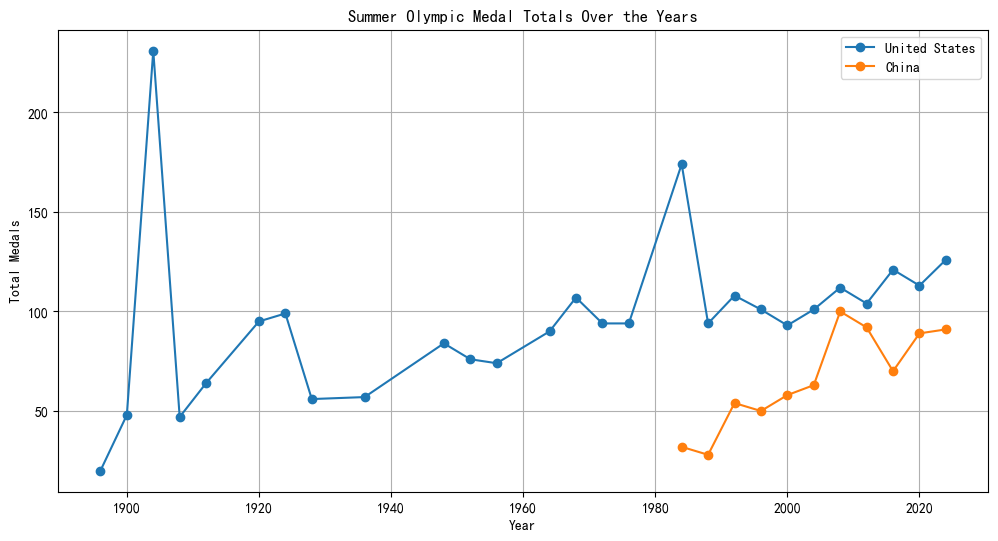

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = medal_counts.copy()

# 数据预处理
# 由于数据格式较为复杂，需要先将其转换为更易于处理的格式
# 提取年份和各个国家的奖牌总数
# 假设我们关注的是美国（United States）和中国的（China）奖牌总数
us_data = data[data['NOC'] == 'United States'][['Year', 'Total']].rename(columns={'Total': 'US_Total'})
china_data = data[data['NOC'] == 'China'][['Year', 'Total']].rename(columns={'Total': 'China_Total'})

# 合并数据
merged_data = pd.merge(us_data, china_data, on='Year', how='outer').sort_values(by='Year')

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Year'], merged_data['US_Total'], label='United States', marker='o')
plt.plot(merged_data['Year'], merged_data['China_Total'], label='China', marker='o')

# 添加标题和图例
plt.title('Summer Olympic Medal Totals Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend()

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

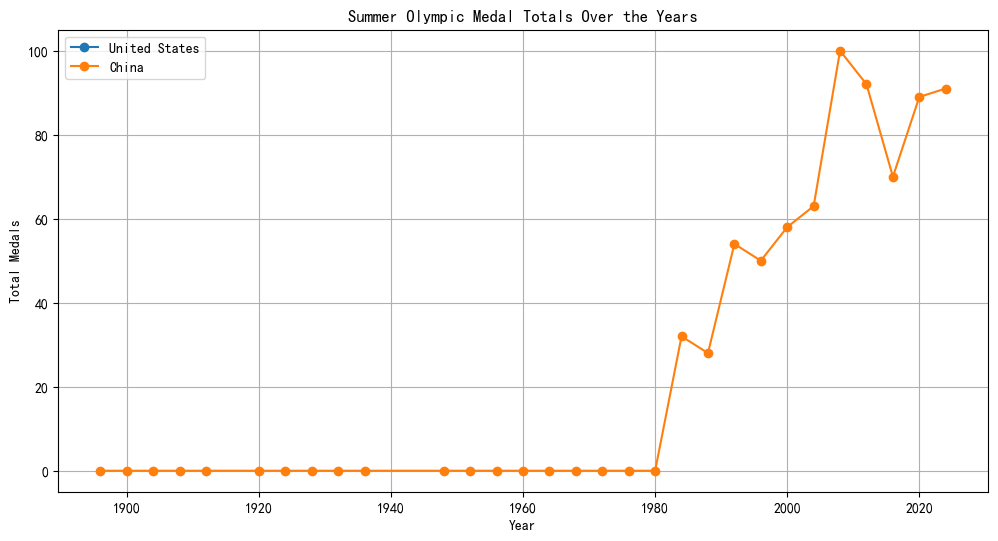

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('Generated\\summerOly_medal_counts_imputed.csv')

# 数据预处理
# 由于数据格式较为复杂，需要先将其转换为更易于处理的格式
# 提取年份和各个国家的奖牌总数
# 假设我们关注的是美国（United States）和中国的（China）奖牌总数
us_data = data[data['NOC'] == 'United States'][['Year', 'Total']].rename(columns={'Total': 'US_Total'})
china_data = data[data['NOC'] == 'China'][['Year', 'Total']].rename(columns={'Total': 'China_Total'})

# 合并数据
merged_data = pd.merge(us_data, china_data, on='Year', how='outer').sort_values(by='Year')

# 绘制折线图
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Year'], merged_data['US_Total'], label='United States', marker='o')
plt.plot(merged_data['Year'], merged_data['China_Total'], label='China', marker='o')

# 添加标题和图例
plt.title('Summer Olympic Medal Totals Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.legend()

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

## 项目级特征

In [38]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('Generated\\summerOly_programs_filled.csv')

# 获取所有年份列
years = [col for col in df.columns if col.isdigit()]

# 初始化一个空的DataFrame来存储结果
result = pd.DataFrame(columns=['Year', 'Amount'])

# 遍历每个年份，计算总项目数
for year in years:
    total_events = df[year].sum()
    new_row = pd.DataFrame({'Year': [int(year)], 'Amount': [int(total_events)]})
    result = pd.concat([result, new_row], ignore_index=True)

# 显示结果
print(result.head())

result.to_csv('Generated\\Project_amount.csv')

   Year Amount
0  1896    113
1  1900    236
2  1904    224
3  1906    176
4  1908    267


### 可视化

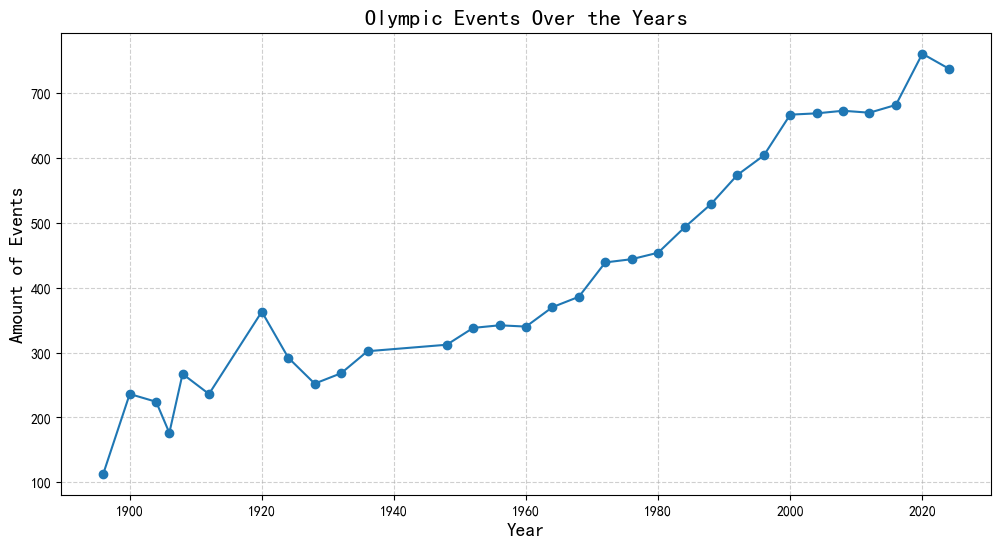

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('Generated\\Project_amount.csv')

# 绘制折线图
plt.figure(figsize=(12, 6))  # 设置图形大小
plt.plot(df['Year'], df['Amount'], marker='o', linestyle='-')  # 绘制折线图，添加标记点

# 添加标题和标签
plt.title('Olympic Events Over the Years', fontsize=16)  # 添加标题
plt.xlabel('Year', fontsize=14)  # 添加x轴标签
plt.ylabel('Amount of Events', fontsize=14)  # 添加y轴标签

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图形
plt.show()

### 线性拟合

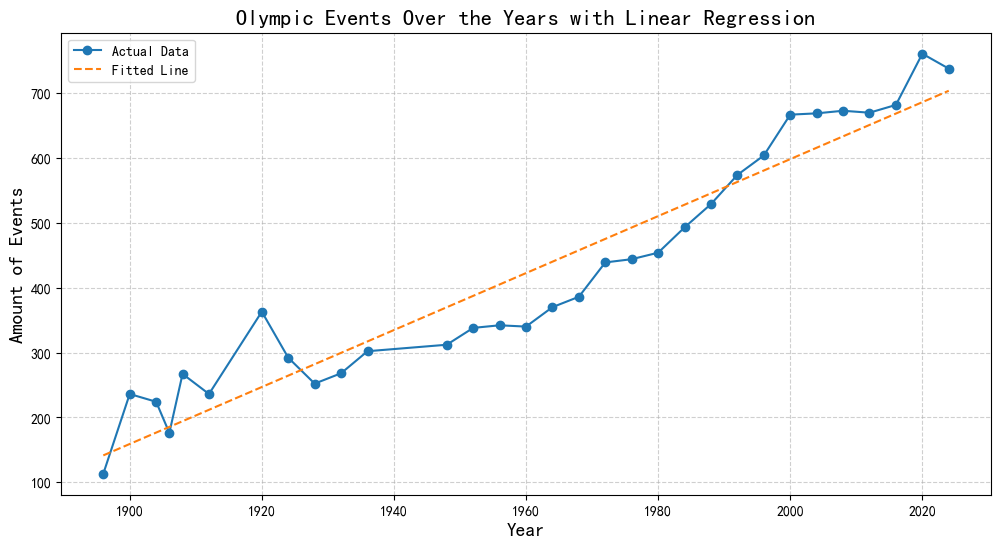

预测2028年的总项目数: 721
决定系数 R^2: 0.9177


In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('Generated\\Project_amount.csv')

# 准备数据
X = df['Year'].values.reshape(-1, 1)  # 将年份作为自变量
y = df['Amount'].values  # 将项目数作为因变量

# 创建线性回归模型
model = LinearRegression()

# 拟合模型
model.fit(X, y)

# 预测2028年的总项目数
year_2028 = np.array([2028]).reshape(-1, 1)
predicted_amount_2028 = model.predict(year_2028)

# 计算决定系数 R^2
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# 绘制折线图和拟合线
plt.figure(figsize=(12, 6))
plt.plot(X, y, marker='o', linestyle='-', label='Actual Data')  # 绘制实际数据
plt.plot(X, y_pred, linestyle='--', label='Fitted Line')  # 绘制拟合线

# 添加标题和标签
plt.title('Olympic Events Over the Years with Linear Regression', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Amount of Events', fontsize=14)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.6)

# 添加图例
plt.legend()

# 显示图形
plt.show()

# 打印预测结果和拟合度
print(f"预测2028年的总项目数: {round(predicted_amount_2028[0])}")
print(f"决定系数 R^2: {r2:.4f}")

## 运动员级特征

### 预处理

In [41]:
# 读取 summerOly_athletes.csv 文件
data = olympic_athletes.copy()

# 提取必要的列
athlete_years = olympic_athletes[['Name', 'Sex', 'NOC', 'Team', 'Year', 'Sport', 'Event']].drop_duplicates()
# 合并Name, Sex, NOC列
athlete_years['Feature'] = athlete_years['Name'] + ', ' + athlete_years['Sex']  + ', ' + athlete_years['NOC']

# 删除原始的Name, Sex, NOC列
#athlete_years = athlete_years.drop(columns=['Name', 'Sex', 'NOC'])

# 对每个运动员进行排序
athlete_years = athlete_years.sort_values(by=['Feature','Year'])
athlete_years.to_csv('Generated\\athlete_yesrs.csv', index=False, encoding='utf-8')

### 添加唯一特征值

In [42]:
import os

# 设置环境变量 LOKY_MAX_CPU_COUNT
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # 使用CPU 核心数

In [43]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# 读取CSV文件
file_path = 'Generated\\athlete_yesrs.csv'  # 替换为你的文件路径
data = pd.read_csv(file_path)

# 显示原始数据的前几行
print("原始数据的前几行：")
print(data.head())

# 设置时间阈值
time_threshold_small = 12
time_threshold_large = 44

# 按Feature分组
grouped = data.groupby('Feature')

# 用于存储处理后的数据
processed_data = []

# 遍历每个分组
for feature, group in grouped:
    # 按Year排序
    group = group.sort_values(by='Year')
    
    # 初始化变量
    unique_feature_count = 0
    last_year = None
    
    # 遍历分组中的每条记录
    for index, row in group.iterrows():
        current_year = row['Year']
        
        # 判断是否为同一个运动员
        if last_year is not None:
            year_diff = current_year - last_year
            if year_diff > time_threshold_large:
                # 如果时间跨度大于44年，直接认为是不同运动员
                unique_feature_count += 1
            elif year_diff > time_threshold_small:
                # 如果时间跨度在12到44年之间，进行聚类分析
                features_cluster = group[['Year', 'Sport', 'Event']].apply(lambda x: x.factorize()[0])
                features_cluster = StandardScaler().fit_transform(features_cluster)
                
                # 使用DBSCAN聚类
                dbscan = DBSCAN(eps=0.5, min_samples=2)
                group['Cluster'] = dbscan.fit_predict(features_cluster)
                
                # 为每个聚类生成唯一标识
                for cluster in group['Cluster'].unique():
                    cluster_group = group[group['Cluster'] == cluster]
                    for _, cluster_row in cluster_group.iterrows():
                        new_feature = f"{feature}_{cluster}"
                        processed_data.append({
                            'Name': cluster_row['Name'],
                            'Sex': cluster_row['Sex'],
                            'Team': cluster_row['Team'],
                            'NOC': cluster_row['NOC'],
                            'Year': cluster_row['Year'],
                            'Sport': cluster_row['Sport'],
                            'Event': cluster_row['Event'],
                            'Feature': new_feature
                        })
                        unique_feature_count += 1
                break  # 已经处理完当前分组，跳出循环
        
        # 如果时间跨度在阈值内，认为是同一个运动员
        new_feature = f"{feature}_{unique_feature_count}"
        processed_data.append({
            'Name': row['Name'],
            'Sex': row['Sex'],
            'Team': row['Team'],
            'NOC': row['NOC'],
            'Year': row['Year'],
            'Sport': row['Sport'],
            'Event': row['Event'],
            'Feature': new_feature
        })
        
        # 更新变量
        last_year = current_year

# 将处理后的数据转换为DataFrame
processed_df = pd.DataFrame(processed_data)

# 显示处理后的数据
print("\n处理后的数据：")
print(processed_df[['Feature', 'Sport', 'Event', 'Year']].head())

# 保存处理后的数据到新的CSV文件
output_file_path = 'Generated\\athlete_years_processed.csv'
processed_df.to_csv(output_file_path, index=False)
print(f"\n处理后的数据已保存到 {output_file_path}")

原始数据的前几行：
            Name Sex  NOC          Team  Year          Sport  \
0   (jr) Larocca   M  ARG     Argentina  2024     Equestrian   
1  . Chadalavada   F  IND         India  2020        Fencing   
2         . Deni   M  INA     Indonesia  2020  Weightlifting   
3            671   F  CHN         China  2024       Breaking   
4       A Alayed   F  KSA  Saudi Arabia  2024       Swimming   

                      Event                Feature  
0        Jumping Individual   (jr) Larocca, M, ARG  
1  Women's Sabre Individual  . Chadalavada, F, IND  
2                Men's 67kg         . Deni, M, INA  
3                   B-Girls            671, F, CHN  
4    Women's 200m Freestyle       A Alayed, F, KSA  

处理后的数据：
                   Feature          Sport                     Event  Year
0   (jr) Larocca, M, ARG_0     Equestrian        Jumping Individual  2024
1  . Chadalavada, F, IND_0        Fencing  Women's Sabre Individual  2020
2         . Deni, M, INA_0  Weightlifting               

### 统计连续参加奥运会的年数与对应人数

In [44]:
# 读取CSV文件
file_path = 'Generated\\athlete_years_processed.csv'  # 替换为你的文件路径
athlete_years = pd.read_csv(file_path)

In [45]:
# 计算连续参加的届数
def count_consecutive_years(group):
    years = group['Year'].sort_values().values
    consecutive_year = []
    current_count = 1
    for i in range(1, len(years)):
        if years[i] - years[i - 1] <= 6 :
            if years[i] - years[i - 1] >= 3:
                current_count += 1
        else:
            if current_count > 10:
                print(group)
            consecutive_year.append(current_count)
            current_count = 1
    consecutive_year.append(current_count)
    return pd.Series(consecutive_year)

# 应用函数计算每个运动员的连续届数
consecutive_years = athlete_years.groupby('Feature').apply(count_consecutive_years, include_groups=False).explode().reset_index()
consecutive_years.columns = ['Feature', 'level_0',  'Consecutive_Years']  # 修正列名
consecutive_years = consecutive_years.drop(columns=['level_0'])  # 删除不必要的列

# 统计每个连续届数的人数
consecutive_years_count = consecutive_years['Consecutive_Years'].value_counts().reset_index()
consecutive_years_count.columns = ['Consecutive_Years', 'Count']

# 输出结果
print("连续参加奥运会的届数与对应人次：")
print(consecutive_years_count)

# 保存为新的 CSV 文件
output_path = 'Generated\\consecutive_years_count.csv'
consecutive_years_count.to_csv(output_path, index=False, encoding='utf-8')
print(f"统计结果已保存到 {output_path}")

连续参加奥运会的届数与对应人次：
   Consecutive_Years   Count
0                  1  108202
1                  2   23470
2                  3    6036
3                  4    1575
4                  5     372
5                  6      79
6                  7      18
7                  8       4
8                  9       1
统计结果已保存到 Generated\consecutive_years_count.csv


#### 数据可视化

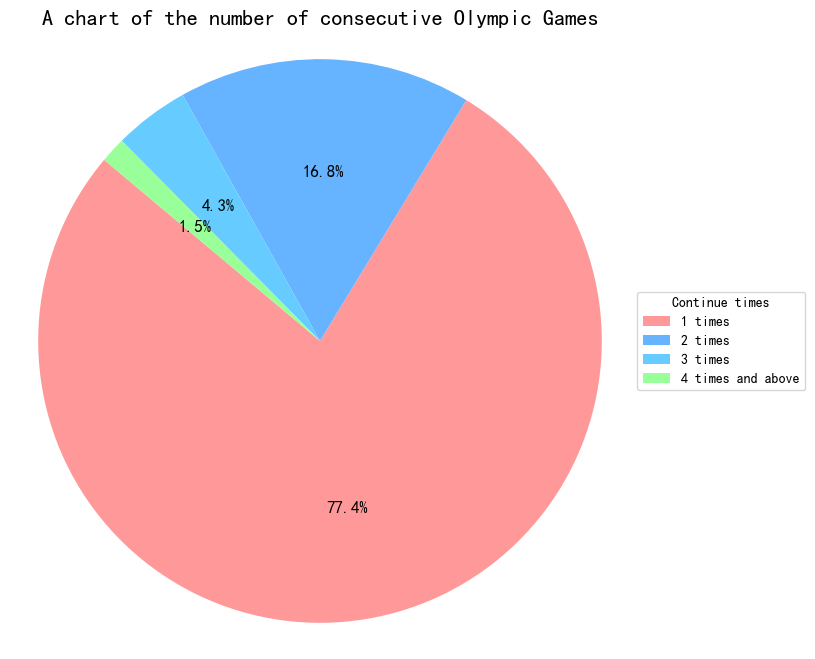

In [46]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取数据
data = pd.read_csv("Generated/consecutive_years_count.csv")

# 定义大致届数区间
bins = [0, 2, 3, 4, 14]
labels = ['1 times', '2 times', '3 times', '4 times and above']

# 将数据分组到区间
data['Group'] = pd.cut(data['Consecutive_Years'], bins=bins, labels=labels, right=False)

# 计算每个区间的总人次，显式设置 observed=True
grouped_data = data.groupby('Group', observed=True)['Count'].sum().reset_index()

# 准备绘图数据
labels = grouped_data['Group']
sizes = grouped_data['Count']
colors = ['#ff9999', '#66b3ff', '#66ccff', '#99ff99']  # 颜色列表

# 绘制饼图
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})

# 添加图例（色块+标签），放置在右侧
plt.legend(wedges, labels, title="Continue times", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('A chart of the number of consecutive Olympic Games', fontsize=16)
plt.axis('equal')  # 确保饼图是圆形
plt.show()

In [47]:
# 保存组别与对应比例
group_percentages = []
for label, autotext in zip(labels, autotexts):
    # 获取百分比文本并去掉百分号，转换为浮点数
    percentage = float(autotext.get_text().strip('%'))
    group_percentages.append((label, percentage))

# 打印结果
print("组别与对应比例：")
for group, percentage in group_percentages:
    print(f"{group}: {percentage:.1f}%")

组别与对应比例：
1 times: 77.4%
2 times: 16.8%
3 times: 4.3%
4 times and above: 1.5%


### 统计运动员参加奥运会的时间跨度

In [48]:
# 读取CSV文件
file_path = 'Generated\\athlete_years_processed.csv'  # 替换为你的文件路径
athlete_years = pd.read_csv(file_path)

In [49]:
# 计算每个运动员的第一次和最后一次参赛年份
def calculate_year_gap(group):
    years = group['Year'].values
    min_n = 2032
    max_n = 1896
    for i in years:
        if i < min_n:
            min_n = i
        if i > max_n:
            max_n = i
    if len(years) > 0:
        if max_n - min_n + 1 > 60:
            #print(group)
            return 1
        return max_n - min_n + 1
    else:
        return 0

# 应用函数计算每个运动员的间隔年数
athlete_gaps = athlete_years.groupby('Feature').apply(calculate_year_gap, include_groups=False).reset_index()
athlete_gaps.columns = ['Feature', 'Year_Gap']

# 统计每个间隔年数的人数
gap_counts = athlete_gaps['Year_Gap'].value_counts().reset_index()
gap_counts.columns = ['Year_Gap', 'Count']

# 按 Year_Gap 排序
gap_counts = gap_counts.sort_values(by='Year_Gap')

# 输出结果
print("运动员第一次参加奥运会和最后一次参加奥运会之间的间隔年数：")
print(gap_counts)

# 保存为新的 CSV 文件
output_path = 'Generated\\athlete_year_gaps.csv'
gap_counts.to_csv(output_path, index=False, encoding='utf-8')
print(f"统计结果已保存到 {output_path}")

运动员第一次参加奥运会和最后一次参加奥运会之间的间隔年数：
    Year_Gap  Count
0          1  99249
8          3     98
1          5  21869
10         7     77
2          9   8014
18        11     12
3         13   2887
15        15     16
4         17    942
19        19      8
5         21    382
20        23      3
6         25    178
21        27      1
7         29    134
22        31      1
9         33     90
11        37     57
12        41     49
24        43      1
13        45     44
14        49     21
17        53     12
16        57     13
23        59      1
统计结果已保存到 Generated\athlete_year_gaps.csv


#### 数据可视化

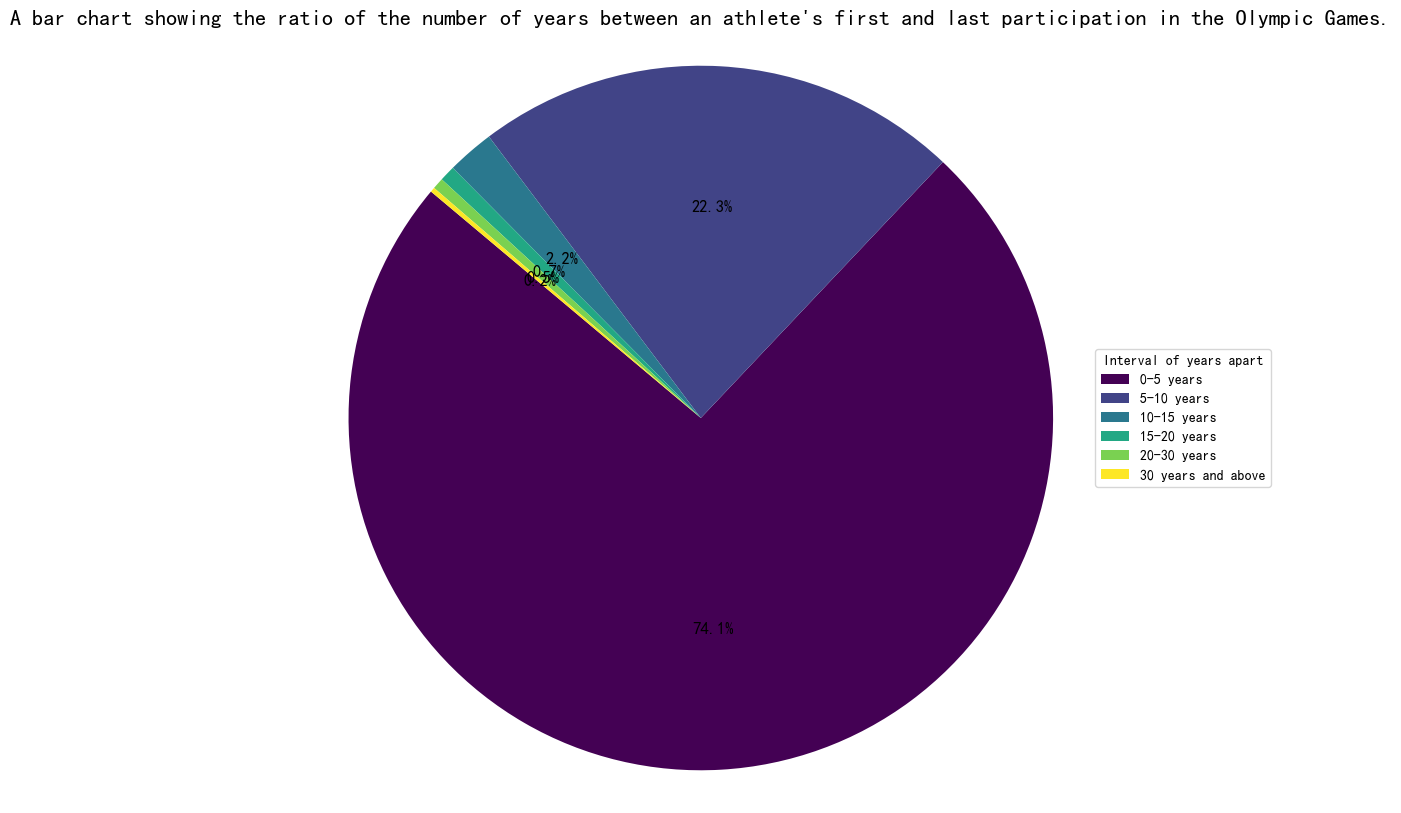

In [50]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取数据
data = pd.read_csv("Generated\\athlete_year_gaps.csv")

# 定义大致间隔年数区间
bins = [0, 5, 10, 15, 20, 30, 120]  # 区间划分：0-5年，5-10年，10-15年，15-20年，20-30年，30年以上
labels = ['0-5 years', '5-10 years', '10-15 years', '15-20 years', '20-30 years', '30 years and above']

# 将数据分组到区间
data['Group'] = pd.cut(data['Year_Gap'], bins=bins, labels=labels, right=False)

# 计算每个区间的总人次
grouped_data = data.groupby('Group', observed=True)['Count'].sum().reset_index()

# 准备绘图数据
labels = grouped_data['Group']
sizes = grouped_data['Count']
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # 使用颜色映射生成颜色列表

# 绘制饼图
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})

# 添加图例（色块+标签），放置在右侧
plt.legend(wedges, labels, title="Interval of years apart", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("A bar chart showing the ratio of the number of years between an athlete's first and last participation in the Olympic Games.", fontsize=16)
plt.axis('equal')  # 确保饼图是圆形
plt.show()

'''根据扇形图，对于运动员连续参加比赛，只考虑连续参加2-3届的运动员的连续性影响，其余影响可以忽略不计。'''

#### 参加时间跨度为0-15年的运动员中连续参加的比例

In [51]:
# 合并时间跨度和连续届数数据
athlete_gaps.to_csv('Generated\\athlete_gaps.csv')
consecutive_years.to_csv('Generated\\consecutive_years.csv')
merged_data = athlete_gaps.merge(consecutive_years, on='Feature')

# 筛选出时间跨度为1-15年的运动员
filtered_data = merged_data[(merged_data['Year_Gap'] >= 1) & (merged_data['Year_Gap'] <= 15)]

# 统计连续参加的比例
total_count = filtered_data.shape[0]
consecutive_count = filtered_data[filtered_data['Year_Gap'] <= filtered_data['Consecutive_Years']*4].shape[0]
consecutive_ratio = consecutive_count / total_count if total_count > 0 else 0

# 输出结果
print(f"时间跨度为1-15年的运动员中，连续参加的比例为：{consecutive_ratio:.2%}")

# 保存结果到 CSV 文件
output_path = 'Generated\\consecutive_ratio.csv'
filtered_data.to_csv(output_path, index=False, encoding='utf-8')
print(f"统计结果已保存到 {output_path}")

时间跨度为1-15年的运动员中，连续参加的比例为：94.51%
统计结果已保存到 Generated\consecutive_ratio.csv


#### 数据可视化

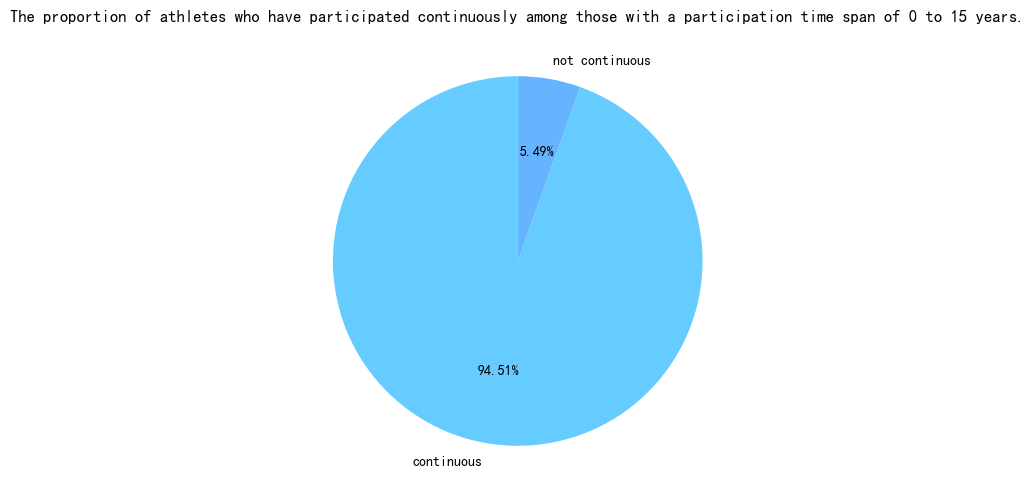

In [52]:
# 导入必要的库
import matplotlib.pyplot as plt

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 数据
percentages = [consecutive_ratio*100, (1-consecutive_ratio)*100]  # 一个百分数和剩余部分
labels = ['continuous', 'not continuous']  # 标签
colors = ['#66ccff', '#66b3ff']  # 颜色

# 绘制饼图
plt.figure(figsize=(6, 6))  # 设置图形大小
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
# autopct='%1.2f%%' 表示在每个扇形上显示百分比，格式为2位小数
# startangle=90 表示从90度（即正上方）开始绘制

# 添加标题
plt.title('The proportion of athletes who have participated continuously among those with a participation time span of 0 to 15 years.')

# 显示图形
plt.show()

#### 结论
- '我们可以发现，参加奥运会时间跨度0-15年中绝大部分运动员都是连续参加的'
- '而且我们前面发现，绝大部分的运动员的时间跨度在0-15年之间，连续参加届数在1-3届'
- '而且我们知道，0-15之间只能连续参加1-3次奥运会'
- '我们因此可以得出结论，绝大部分奥运会运动员连续参加了1-3次奥运会'
- '所以我们可以得出结论，考虑运动员连续参加比赛对奖牌的影响只需要考虑连续参加2-3次的情况'

In [53]:
first_percentage = group_percentages[1][1]/(group_percentages[0][1]+group_percentages[1][1]+group_percentages[2][1]+group_percentages[3][1])*100
print(f'一个参加了一次奥运会的运动员参加下一次奥运会的可能为{first_percentage : .2f}' + '%')
second_percentage = group_percentages[2][1]/(group_percentages[1][1]+group_percentages[2][1]+group_percentages[3][1])*100
print(f'一个参加了两次奥运会的运动员参加下一次奥运会的可能为{second_percentage : .2f}' + '%')
third_percentage = group_percentages[3][1]/(group_percentages[2][1]+group_percentages[3][1])*100
print(f'一个参加了三次奥运会的运动员参加下一次奥运会的可能为{third_percentage : .2f}' + '%')
athlete_join_willing = {1 : first_percentage, 2 : second_percentage, 3 : third_percentage}

一个参加了一次奥运会的运动员参加下一次奥运会的可能为 16.80%
一个参加了两次奥运会的运动员参加下一次奥运会的可能为 19.03%
一个参加了三次奥运会的运动员参加下一次奥运会的可能为 25.86%


# 构建模型

## XGBoost

### 直接预测（超参数优化）

In [54]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

#scikit-learn==1.5.2

# 加载数据
data = pd.read_csv('Generated\\summerOly_medal_counts_processed.csv')

# 数据预处理
# 将国家代码转换为数值标签
label_encoder = LabelEncoder()
data['NOC'] = label_encoder.fit_transform(data['NOC'])

# 处理缺失值
data = data.fillna(0)

# 创建特征：前一届奥运会的奖牌总数、金牌数、银牌数、铜牌数
data['Prev_Total'] = data.groupby('NOC')['Total'].shift(1)
data['Prev_Gold'] = data.groupby('NOC')['Gold'].shift(1)
data['Prev_Silver'] = data.groupby('NOC')['Silver'].shift(1)
data['Prev_Bronze'] = data.groupby('NOC')['Bronze'].shift(1)

# 填充缺失值
data['Prev_Total'] = data['Prev_Total'].fillna(0)
data['Prev_Gold'] = data['Prev_Gold'].fillna(0)
data['Prev_Silver'] = data['Prev_Silver'].fillna(0)
data['Prev_Bronze'] = data['Prev_Bronze'].fillna(0)

# 选择特征和目标变量
features = data[['Year', 'NOC', 'Prev_Total', 'Prev_Gold', 'Prev_Silver', 'Prev_Bronze']]
target_total = data['Total']
target_gold = data['Gold']
target_silver = data['Silver']
target_bronze = data['Bronze']

# 划分训练集和测试集
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(features, target_total, test_size=0.2, random_state=42)
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(features, target_gold, test_size=0.2, random_state=42)
X_train_silver, X_test_silver, y_train_silver, y_test_silver = train_test_split(features, target_silver, test_size=0.2, random_state=42)
X_train_bronze, X_test_bronze, y_train_bronze, y_test_bronze = train_test_split(features, target_bronze, test_size=0.2, random_state=42)

X_test = pd.DataFrame({'Total' : [X_test_total],
          'Gold' : [X_test_gold],
          'Silver' : [X_test_silver],
          'Bronze' : [X_test_bronze],
          })
y_test = pd.DataFrame({'Total' : [y_test_total],
          'Gold' : [y_test_gold],
          'Silver' : [y_test_silver],
          'Bronze' : [y_test_bronze],
          })

# 启用 GPU 加速
params = {
    #'tree_method' : "hist",
    #'device' : "cuda",
    #'predictor': 'gpu_predictor',  # 使用 GPU 进行预测
    'objective': 'reg:squarederror',
    'random_state': '42'
}


# 定义XGBoost模型
model_total = XGBRegressor(**params)
model_gold = XGBRegressor(**params)
model_silver = XGBRegressor(**params)
model_bronze = XGBRegressor(**params)

# 超参数优化
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

# 使用GridSearchCV进行超参数优化
grid_search_total = GridSearchCV(estimator=model_total, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gold = GridSearchCV(estimator=model_gold, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_silver = GridSearchCV(estimator=model_silver, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_bronze = GridSearchCV(estimator=model_bronze, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# 训练模型
grid_search_total.fit(X_train_total, y_train_total)
grid_search_gold.fit(X_train_gold, y_train_gold)
grid_search_silver.fit(X_train_silver, y_train_silver)
grid_search_bronze.fit(X_train_bronze, y_train_bronze)

# 获取最佳模型
best_model_total = grid_search_total.best_estimator_
best_model_gold = grid_search_gold.best_estimator_
best_model_silver = grid_search_silver.best_estimator_
best_model_bronze = grid_search_bronze.best_estimator_

# 评估模型
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE: {mse}')
    return y_pred

print("Total Medals Model Evaluation:")
evaluate_model(best_model_total, X_test_total, y_test_total)

print("Gold Medals Model Evaluation:")
evaluate_model(best_model_gold, X_test_gold, y_test_gold)

print("Silver Medals Model Evaluation:")
evaluate_model(best_model_silver, X_test_silver, y_test_silver)

print("Bronze Medals Model Evaluation:")
evaluate_model(best_model_bronze, X_test_bronze, y_test_bronze)

# 定义超参数网格
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 为每个国家单独训练模型
country_models = {}
for country in data['NOC'].unique():
    country_data = data[data['NOC'] == country]
    if len(country_data) > 1:  # 确保每个国家至少有两条记录
        country_data = country_data.replace([np.inf, -np.inf], np.nan)  # 替换无穷值为NaN
        country_data = country_data.ffill()  # 前向填充
        country_data = country_data.bfill()  # 后向填充
        country_features = country_data[['Year', 'NOC', 'Prev_Total', 'Prev_Gold', 'Prev_Silver', 'Prev_Bronze']]
        country_target_total = country_data['Total']
        country_target_gold = country_data['Gold']
        country_target_silver = country_data['Silver']
        country_target_bronze = country_data['Bronze']
        
        country_model_total = XGBRegressor(**params)
        country_model_gold = XGBRegressor(**params)
        country_model_silver = XGBRegressor(**params)
        country_model_bronze = XGBRegressor(**params)

        # 使用GridSearchCV进行超参数优化
        grid_search_country_model_total = GridSearchCV(estimator=country_model_total, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search_country_model_gold = GridSearchCV(estimator=country_model_gold, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search_country_model_silver = GridSearchCV(estimator=country_model_silver, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search_country_model_bronze = GridSearchCV(estimator=country_model_bronze, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        
        grid_search_country_model_total.fit(country_features, country_target_total)
        grid_search_country_model_gold.fit(country_features, country_target_gold)
        grid_search_country_model_silver.fit(country_features, country_target_silver)
        grid_search_country_model_bronze.fit(country_features, country_target_bronze)

        # 获取最佳模型
        best_country_model_total = grid_search_country_model_total.best_estimator_
        best_country_model_gold = grid_search_country_model_gold.best_estimator_
        best_country_model_silver = grid_search_country_model_silver.best_estimator_
        best_country_model_bronze = grid_search_country_model_bronze.best_estimator_
        
        # 评估性能
        print("Total Medals Model Evaluation:")
        evaluate_model(best_country_model_total, X_test_total, y_test_total)
        print("Gold Medals Model Evaluation:")
        evaluate_model(best_country_model_gold, X_test_gold, y_test_gold)
        print("Silver Medals Model Evaluation:")
        evaluate_model(best_country_model_silver, X_test_silver, y_test_silver)
        print("Bronze Medals Model Evaluation:")
        evaluate_model(best_country_model_bronze, X_test_bronze, y_test_bronze)

        country_models[country] = {
            'total': best_country_model_total,
            'gold': best_country_model_gold,
            'silver': best_country_model_silver,
            'bronze': best_country_model_bronze
        }

# 预测2028年奥运会的奖牌数
next_year = 2028
predictions = []

for country in data['NOC'].unique():
    country_data = data[data['NOC'] == country]
    if len(country_data) > 1:
        prev_total = country_data['Total'].iloc[-1]
        prev_gold = country_data['Gold'].iloc[-1]
        prev_silver = country_data['Silver'].iloc[-1]
        prev_bronze = country_data['Bronze'].iloc[-1]
        
        next_data = pd.DataFrame({
            'Year': [next_year],
            'NOC': [country],
            'Prev_Total': [prev_total],
            'Prev_Gold': [prev_gold],
            'Prev_Silver': [prev_silver],
            'Prev_Bronze': [prev_bronze]
        })
        
        # 使用单独模型预测
        total_pred = country_models[country]['total'].predict(next_data)
        gold_pred = country_models[country]['gold'].predict(next_data)
        silver_pred = country_models[country]['silver'].predict(next_data)
        bronze_pred = country_models[country]['bronze'].predict(next_data)
        
        # 使用整体模型预测
        total_pred_global = best_model_total.predict(next_data)
        gold_pred_global = best_model_gold.predict(next_data)
        silver_pred_global = best_model_silver.predict(next_data)
        bronze_pred_global = best_model_bronze.predict(next_data)
        
        # 根据数据量分配权重
        data_count = len(country_data)
        weight = min(data_count / 10, 1)  # 数据量越多，权重越高，但不超过1
        total_pred_combined = weight * total_pred + (1 - weight) * total_pred_global
        gold_pred_combined = weight * gold_pred + (1 - weight) * gold_pred_global
        silver_pred_combined = weight * silver_pred + (1 - weight) * silver_pred_global
        bronze_pred_combined = weight * bronze_pred + (1 - weight) * bronze_pred_global
        
        # 对预测结果取整
        total_pred_combined = round(total_pred_combined[0])
        gold_pred_combined = round(gold_pred_combined[0])
        silver_pred_combined = round(silver_pred_combined[0])
        bronze_pred_combined = round(bronze_pred_combined[0])
        
        predictions.append({
            'NOC': country,
            'Total_Predicted': total_pred_combined,
            'Gold_Predicted': gold_pred_combined,
            'Silver_Predicted': silver_pred_combined,
            'Bronze_Predicted': bronze_pred_combined
        })

# 将预测结果转换为DataFrame
predictions_df = pd.DataFrame(predictions)

# 将NOC标签转换回国家代码
predictions_df['NOC'] = label_encoder.inverse_transform(predictions_df['NOC'])

# 输出预测结果
print(predictions_df)

# 保存预测结果到CSV文件
predictions_df.to_csv('Result\\2028_olympics_medal_predictions.csv', index=False)

Total Medals Model Evaluation:
MSE: 14.183948320207696
Gold Medals Model Evaluation:
MSE: 2.9414593946059715
Silver Medals Model Evaluation:
MSE: 1.8287626291987034
Bronze Medals Model Evaluation:
MSE: 2.185780634244944
Total Medals Model Evaluation:
MSE: 140.75342068015084
Gold Medals Model Evaluation:
MSE: 18.508602150537634
Silver Medals Model Evaluation:
MSE: 15.480645161290322
Bronze Medals Model Evaluation:
MSE: 15.818427348076781
Total Medals Model Evaluation:
MSE: 142.85282353556897
Gold Medals Model Evaluation:
MSE: 18.508602150537634
Silver Medals Model Evaluation:
MSE: 15.480645161290322
Bronze Medals Model Evaluation:
MSE: 16.57628960602166
Total Medals Model Evaluation:
MSE: 122.58495074211991
Gold Medals Model Evaluation:
MSE: 17.402119733106872
Silver Medals Model Evaluation:
MSE: 14.068511301831862
Bronze Medals Model Evaluation:
MSE: 12.350547132239438
Total Medals Model Evaluation:
MSE: 117.61289573977655
Gold Medals Model Evaluation:
MSE: 15.07693219210729
Silver Med

### 非超参数优化模型

In [55]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 加载数据
data = pd.read_csv('Generated\\summerOly_medal_counts_processed.csv')

# 数据预处理
# 将国家代码转换为数值标签
label_encoder = LabelEncoder()
data['NOC'] = label_encoder.fit_transform(data['NOC'])

# 处理缺失值
data = data.fillna(0)

# 创建特征：前一届奥运会的奖牌总数、金牌数、银牌数、铜牌数
data['Prev_Total'] = data.groupby('NOC')['Total'].shift(1)
data['Prev_Gold'] = data.groupby('NOC')['Gold'].shift(1)
data['Prev_Silver'] = data.groupby('NOC')['Silver'].shift(1)
data['Prev_Bronze'] = data.groupby('NOC')['Bronze'].shift(1)

# 填充缺失值
data['Prev_Total'] = data['Prev_Total'].fillna(0)
data['Prev_Gold'] = data['Prev_Gold'].fillna(0)
data['Prev_Silver'] = data['Prev_Silver'].fillna(0)
data['Prev_Bronze'] = data['Prev_Bronze'].fillna(0)

# 选择特征和目标变量
features = data[['Year', 'NOC', 'Prev_Total', 'Prev_Gold', 'Prev_Silver', 'Prev_Bronze']]
target_total = data['Total']
target_gold = data['Gold']
target_silver = data['Silver']
target_bronze = data['Bronze']

# 划分训练集和测试集
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(features, target_total, test_size=0.2, random_state=42)
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(features, target_gold, test_size=0.2, random_state=42)
X_train_silver, X_test_silver, y_train_silver, y_test_silver = train_test_split(features, target_silver, test_size=0.2, random_state=42)
X_train_bronze, X_test_bronze, y_train_bronze, y_test_bronze = train_test_split(features, target_bronze, test_size=0.2, random_state=42)

# 定义XGBoost模型
model_total = XGBRegressor(objective='reg:squarederror', random_state=42)
model_gold = XGBRegressor(objective='reg:squarederror', random_state=42)
model_silver = XGBRegressor(objective='reg:squarederror', random_state=42)
model_bronze = XGBRegressor(objective='reg:squarederror', random_state=42)

# 超参数优化
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

# 使用GridSearchCV进行超参数优化
grid_search_total = GridSearchCV(estimator=model_total, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gold = GridSearchCV(estimator=model_gold, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_silver = GridSearchCV(estimator=model_silver, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_bronze = GridSearchCV(estimator=model_bronze, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# 训练模型
grid_search_total.fit(X_train_total, y_train_total)
grid_search_gold.fit(X_train_gold, y_train_gold)
grid_search_silver.fit(X_train_silver, y_train_silver)
grid_search_bronze.fit(X_train_bronze, y_train_bronze)

# 获取最佳模型
best_model_total = grid_search_total.best_estimator_
best_model_gold = grid_search_gold.best_estimator_
best_model_silver = grid_search_silver.best_estimator_
best_model_bronze = grid_search_bronze.best_estimator_

# 评估模型
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE: {mse}')
    return y_pred

print("Total Medals Model Evaluation:")
evaluate_model(best_model_total, X_test_total, y_test_total)

print("Gold Medals Model Evaluation:")
evaluate_model(best_model_gold, X_test_gold, y_test_gold)

print("Silver Medals Model Evaluation:")
evaluate_model(best_model_silver, X_test_silver, y_test_silver)

print("Bronze Medals Model Evaluation:")
evaluate_model(best_model_bronze, X_test_bronze, y_test_bronze)

# 为每个国家单独训练模型
country_models = {}
for country in data['NOC'].unique():
    country_data = data[data['NOC'] == country]
    if len(country_data) > 1:  # 确保每个国家至少有两条记录
        country_features = country_data[['Year','NOC', 'Prev_Total', 'Prev_Gold', 'Prev_Silver', 'Prev_Bronze']]
        country_target_total = country_data['Total']
        country_target_gold = country_data['Gold']
        country_target_silver = country_data['Silver']
        country_target_bronze = country_data['Bronze']
        
        country_model_total = XGBRegressor(objective='reg:squarederror', random_state=42)
        country_model_gold = XGBRegressor(objective='reg:squarederror', random_state=42)
        country_model_silver = XGBRegressor(objective='reg:squarederror', random_state=42)
        country_model_bronze = XGBRegressor(objective='reg:squarederror', random_state=42)
        
        country_model_total.fit(country_features, country_target_total)
        country_model_gold.fit(country_features, country_target_gold)
        country_model_silver.fit(country_features, country_target_silver)
        country_model_bronze.fit(country_features, country_target_bronze)
        
        country_models[country] = {
            'total': country_model_total,
            'gold': country_model_gold,
            'silver': country_model_silver,
            'bronze': country_model_bronze
        }

# 预测2028年奥运会的奖牌数
next_year = 2028
predictions = []

for country in data['NOC'].unique():
    country_data = data[data['NOC'] == country]
    if len(country_data) > 1:
        prev_total = country_data['Total'].iloc[-1]
        prev_gold = country_data['Gold'].iloc[-1]
        prev_silver = country_data['Silver'].iloc[-1]
        prev_bronze = country_data['Bronze'].iloc[-1]
        
        next_data = pd.DataFrame({
            'Year': [next_year],
            'NOC': [country],  # 添加NOC列
            'Prev_Total': [prev_total],
            'Prev_Gold': [prev_gold],
            'Prev_Silver': [prev_silver],
            'Prev_Bronze': [prev_bronze]
        })
        
        # 使用单独模型预测
        total_pred = country_models[country]['total'].predict(next_data)
        gold_pred = country_models[country]['gold'].predict(next_data)
        silver_pred = country_models[country]['silver'].predict(next_data)
        bronze_pred = country_models[country]['bronze'].predict(next_data)
        
        # 使用整体模型预测
        total_pred_global = best_model_total.predict(next_data)
        gold_pred_global = best_model_gold.predict(next_data)
        silver_pred_global = best_model_silver.predict(next_data)
        bronze_pred_global = best_model_bronze.predict(next_data)
        
        # 根据数据量分配权重
        data_count = len(country_data)
        weight = min(data_count / 10, 1)  # 数据量越多，权重越高，但不超过1
        total_pred_combined = weight * total_pred + (1 - weight) * total_pred_global
        gold_pred_combined = weight * gold_pred + (1 - weight) * gold_pred_global
        silver_pred_combined = weight * silver_pred + (1 - weight) * silver_pred_global
        bronze_pred_combined = weight * bronze_pred + (1 - weight) * bronze_pred_global
        
        # 对预测结果取整
        total_pred_combined = round(total_pred_combined[0])
        gold_pred_combined = round(gold_pred_combined[0])
        silver_pred_combined = round(silver_pred_combined[0])
        bronze_pred_combined = round(bronze_pred_combined[0])
        
        predictions.append({
            'NOC': country,
            'Total_Predicted': total_pred_combined,
            'Gold_Predicted': gold_pred_combined,
            'Silver_Predicted': silver_pred_combined,
            'Bronze_Predicted': bronze_pred_combined
        })

# 将预测结果转换为DataFrame
predictions_df = pd.DataFrame(predictions)

# 将NOC标签转换回国家代码
predictions_df['NOC'] = label_encoder.inverse_transform(predictions_df['NOC'])

# 输出预测结果
print(predictions_df)

# 保存预测结果到CSV文件
predictions_df.to_csv('Result\\2028_olympics_medal_predictions_2.csv', index=False)

Total Medals Model Evaluation:
MSE: 14.183948320207696
Gold Medals Model Evaluation:
MSE: 2.9414593946059715
Silver Medals Model Evaluation:
MSE: 1.8287626291987034
Bronze Medals Model Evaluation:
MSE: 2.185780634244944
               NOC  Total_Predicted  Gold_Predicted  Silver_Predicted  \
0      Afghanistan                1               0                 0   
1          Albania                2               0                 0   
2          Algeria                5               2                 0   
3        Argentina                3               1                 1   
4          Armenia                4               0                 3   
..             ...              ...             ...               ...   
150      Venezuela                3               1                 2   
151        Vietnam                1               0                 1   
152  VirginIslands                0               0                 0   
153         Zambia                1               

### 评估预测区间

In [56]:
import math

# 加载数据
data = pd.read_csv('Generated\\summerOly_medal_counts_processed.csv')
predictions_df = pd.read_csv('Result\\2028_olympics_medal_predictions_2.csv')

# 数据预处理
# 将国家代码转换为数值标签
label_encoder = LabelEncoder()
data['NOC2'] = data['NOC'].copy()
data['NOC'] = label_encoder.fit_transform(data['NOC'])
predictions_df['NOC2'] = predictions_df['NOC'].copy() 
predictions_df['NOC'] = label_encoder.fit_transform(predictions_df['NOC'])

# 输出预测结果
print(predictions_df)

# 处理缺失值
data = data.fillna(0)

# 创建特征：前一届奥运会的奖牌总数、金牌数、银牌数、铜牌数
data['Prev_Total'] = data.groupby('NOC')['Total'].shift(1)
data['Prev_Gold'] = data.groupby('NOC')['Gold'].shift(1)
data['Prev_Silver'] = data.groupby('NOC')['Silver'].shift(1)
data['Prev_Bronze'] = data.groupby('NOC')['Bronze'].shift(1)

# 填充缺失值
data['Prev_Total'] = data['Prev_Total'].fillna(0)
data['Prev_Gold'] = data['Prev_Gold'].fillna(0)
data['Prev_Silver'] = data['Prev_Silver'].fillna(0)
data['Prev_Bronze'] = data['Prev_Bronze'].fillna(0)

def evaluate_model_2(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'MSE: {mse}')
    return mse

# 计算预测区间
def prediction_interval(model, X, y, confidence=0.95):
    # 评估区间
    interval_get = math.sqrt(int(evaluate_model_2(model, X, y)))
    preds = []
    for i in range(10):  # 进行10次预测以估计不确定性
        preds.append(model.predict(X))
    preds = np.array(preds)
    lower = np.percentile(preds, (1 - confidence) / 2 * 100, axis=0) - round(interval_get/2)
    upper = np.percentile(preds, (1 + confidence) / 2 * 100, axis=0) + round(interval_get/2)
    return lower, upper

# 计算每个国家的预测区间
prediction_intervals = []
for country in data['NOC'].unique():
    country_data = data[data['NOC'] == country]
    print(country, label_encoder.inverse_transform([country])[0])
    if len(country_data) > 1:
        prev_total = country_data['Total'].iloc[-1]
        prev_gold = country_data['Gold'].iloc[-1]
        prev_silver = country_data['Silver'].iloc[-1]
        prev_bronze = country_data['Bronze'].iloc[-1]
        
        next_data = pd.DataFrame({
            'Year': [next_year],
            'NOC': [country],
            'Prev_Total': [prev_total],
            'Prev_Gold': [prev_gold],
            'Prev_Silver': [prev_silver],
            'Prev_Bronze': [prev_bronze]
        })
        
        total_lower, total_upper = prediction_interval(country_models[country]['total'], next_data, country_data['Total'][country_data['Year']==2024], 0.95)
        gold_lower, gold_upper = prediction_interval(country_models[country]['gold'], next_data, country_data['Gold'][country_data['Year']==2024], 0.95)
        silver_lower, silver_upper = prediction_interval(country_models[country]['silver'], next_data, country_data['Silver'][country_data['Year']==2024], 0.95)
        bronze_lower, bronze_upper = prediction_interval(country_models[country]['bronze'], next_data, country_data['Bronze'][country_data['Year']==2024], 0.95)
        
        prediction_intervals.append({
            'NOC': country,
            'Total_Predicted': predictions_df.loc[predictions_df['NOC2'] == label_encoder.inverse_transform([country])[0], 'Total_Predicted'].values[0],
            'Total_Lower': round(total_lower[0]),
            'Total_Upper': round(total_upper[0]),
            'Gold_Predicted': predictions_df.loc[predictions_df['NOC2'] == label_encoder.inverse_transform([country])[0], 'Gold_Predicted'].values[0],
            'Gold_Lower': round(gold_lower[0]),
            'Gold_Upper': round(gold_upper[0]),
            'Silver_Predicted': predictions_df.loc[predictions_df['NOC2'] == label_encoder.inverse_transform([country])[0], 'Silver_Predicted'].values[0],
            'Silver_Lower': round(silver_lower[0]),
            'Silver_Upper': round(silver_upper[0]),
            'Bronze_Predicted': predictions_df.loc[predictions_df['NOC2'] == label_encoder.inverse_transform([country])[0], 'Bronze_Predicted'].values[0],
            'Bronze_Lower': round(bronze_lower[0]),
            'Bronze_Upper': round(bronze_upper[0])
        })

# 将预测区间转换为DataFrame
prediction_intervals_df = pd.DataFrame(prediction_intervals)

# 将NOC标签转换回国家代码
prediction_intervals_df['NOC'] = label_encoder.inverse_transform(prediction_intervals_df['NOC'])

# 输出预测区间
print(prediction_intervals_df)

# 保存预测区间到CSV文件
prediction_intervals_df.to_csv('Result\\2028_olympics_medal_predictions_intervals.csv', index=False)

     NOC  Total_Predicted  Gold_Predicted  Silver_Predicted  Bronze_Predicted  \
0      0                1               0                 0                 1   
1      1                2               0                 0                 2   
2      2                5               2                 0                 2   
3      3                3               1                 1                 1   
4      4                4               0                 3                 1   
..   ...              ...             ...               ...               ...   
150  150                3               1                 2                 0   
151  151                1               0                 1                 0   
152  152                0               0                 0                 0   
153  153                1               0                 0                 1   
154  154                3               1                 2                 0   

              NOC2  
0     

- 结论：XGBoost已经训练好的模型的值趋近于不变

## 贝叶斯方法

### 先验预测

In [57]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 加载数据
data = pd.read_csv('Generated\\summerOly_medal_counts_processed.csv')

# 数据预处理
# 将国家代码转换为数值标签
label_encoder = LabelEncoder()
data['NOC'] = label_encoder.fit_transform(data['NOC'])

# 处理缺失值
data = data.fillna(0)

# 创建特征：前一届奥运会的奖牌总数、金牌数、银牌数、铜牌数
data['Prev_Total'] = data.groupby('NOC')['Total'].shift(1)
data['Prev_Gold'] = data.groupby('NOC')['Gold'].shift(1)
data['Prev_Silver'] = data.groupby('NOC')['Silver'].shift(1)
data['Prev_Bronze'] = data.groupby('NOC')['Bronze'].shift(1)

# 填充缺失值
data['Prev_Total'] = data['Prev_Total'].fillna(0)
data['Prev_Gold'] = data['Prev_Gold'].fillna(0)
data['Prev_Silver'] = data['Prev_Silver'].fillna(0)
data['Prev_Bronze'] = data['Prev_Bronze'].fillna(0)

# 选择特征和目标变量
features = data[['Year', 'NOC', 'Prev_Total', 'Prev_Gold', 'Prev_Silver', 'Prev_Bronze']]
target_total = data['Total']
target_gold = data['Gold']
target_silver = data['Silver']
target_bronze = data['Bronze']

# 划分训练集和测试集
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(features, target_total, test_size=0.2, random_state=42)
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(features, target_gold, test_size=0.2, random_state=42)
X_train_silver, X_test_silver, y_train_silver, y_test_silver = train_test_split(features, target_silver, test_size=0.2, random_state=42)
X_train_bronze, X_test_bronze, y_train_bronze, y_test_bronze = train_test_split(features, target_bronze, test_size=0.2, random_state=42)

# 定义XGBoost模型
model_total = XGBRegressor(objective='reg:squarederror', random_state=42)
model_gold = XGBRegressor(objective='reg:squarederror', random_state=42)
model_silver = XGBRegressor(objective='reg:squarederror', random_state=42)
model_bronze = XGBRegressor(objective='reg:squarederror', random_state=42)

# 超参数优化
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9]
}

# 使用GridSearchCV进行超参数优化
grid_search_total = GridSearchCV(estimator=model_total, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gold = GridSearchCV(estimator=model_gold, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_silver = GridSearchCV(estimator=model_silver, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_bronze = GridSearchCV(estimator=model_bronze, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# 训练模型
grid_search_total.fit(X_train_total, y_train_total)
grid_search_gold.fit(X_train_gold, y_train_gold)
grid_search_silver.fit(X_train_silver, y_train_silver)
grid_search_bronze.fit(X_train_bronze, y_train_bronze)

# 获取最佳模型
best_model_total = grid_search_total.best_estimator_
best_model_gold = grid_search_gold.best_estimator_
best_model_silver = grid_search_silver.best_estimator_
best_model_bronze = grid_search_bronze.best_estimator_

# 评估模型
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'MSE: {mse}, R2: {r2}, MAE: {mae}')
    return y_pred

print("Total Medals Model Evaluation:")
evaluate_model(best_model_total, X_test_total, y_test_total)

print("Gold Medals Model Evaluation:")
evaluate_model(best_model_gold, X_test_gold, y_test_gold)

print("Silver Medals Model Evaluation:")
evaluate_model(best_model_silver, X_test_silver, y_test_silver)

print("Bronze Medals Model Evaluation:")
evaluate_model(best_model_bronze, X_test_bronze, y_test_bronze)

# 贝叶斯更新
def bayesian_update(prior_mean, prior_std, new_data):
    if np.isnan(prior_mean) or np.isnan(prior_std) or np.isnan(new_data).any():
        return np.nan, np.nan
    
    n = len(new_data)
    new_mean = np.mean(new_data)
    new_std = np.std(new_data)
    
    # 避免除以零
    if prior_std == 0:
        prior_std = 1e-6
    if new_std == 0:
        new_std = 1e-6
    
    # 更新后验分布的参数
    posterior_mean = (prior_mean / prior_std**2 + new_mean * n / new_std**2) / (1 / prior_std**2 + n / new_std**2)
    posterior_std = np.sqrt(1 / (1 / prior_std**2 + n / new_std**2))
    
    return posterior_mean, posterior_std

# 使用历史数据作为先验分布
prior_mean_total = np.mean(data['Total'])
prior_std_total = np.std(data['Total'])
prior_mean_gold = np.mean(data['Gold'])
prior_std_gold = np.std(data['Gold'])
prior_mean_silver = np.mean(data['Silver'])
prior_std_silver = np.std(data['Silver'])
prior_mean_bronze = np.mean(data['Bronze'])
prior_std_bronze = np.std(data['Bronze'])

# 为每个国家单独训练模型
country_models = {}
for country in data['NOC'].unique():
    country_data = data[data['NOC'] == country]
    if len(country_data) > 1:  # 确保每个国家至少有两条记录
        country_features = country_data[['Year', 'NOC', 'Prev_Total', 'Prev_Gold', 'Prev_Silver', 'Prev_Bronze']]
        country_target_total = country_data['Total']
        country_target_gold = country_data['Gold']
        country_target_silver = country_data['Silver']
        country_target_bronze = country_data['Bronze']
        
        country_model_total = XGBRegressor(objective='reg:squarederror', random_state=42)
        country_model_gold = XGBRegressor(objective='reg:squarederror', random_state=42)
        country_model_silver = XGBRegressor(objective='reg:squarederror', random_state=42)
        country_model_bronze = XGBRegressor(objective='reg:squarederror', random_state=42)
        
        country_model_total.fit(country_features, country_target_total)
        country_model_gold.fit(country_features, country_target_gold)
        country_model_silver.fit(country_features, country_target_silver)
        country_model_bronze.fit(country_features, country_target_bronze)
        
        country_models[country] = {
            'total': country_model_total,
            'gold': country_model_gold,
            'silver': country_model_silver,
            'bronze': country_model_bronze
        }

# 预测2028年奥运会的奖牌数
next_year = 2028
predictions = []

for country in data['NOC'].unique():
    country_data = data[data['NOC'] == country]
    if len(country_data) > 1:
        prev_total = country_data['Total'].iloc[-1]
        prev_gold = country_data['Gold'].iloc[-1]
        prev_silver = country_data['Silver'].iloc[-1]
        prev_bronze = country_data['Bronze'].iloc[-1]
        
        next_data = pd.DataFrame({
            'Year': [next_year],
            'NOC': [country],
            'Prev_Total': [prev_total],
            'Prev_Gold': [prev_gold],
            'Prev_Silver': [prev_silver],
            'Prev_Bronze': [prev_bronze]
        })
        
        # 使用单独模型预测
        total_pred_private = country_models[country]['total'].predict(next_data)
        gold_pred_private = country_models[country]['gold'].predict(next_data)
        silver_pred_private = country_models[country]['silver'].predict(next_data)
        bronze_pred_private = country_models[country]['bronze'].predict(next_data)
        
        # 使用整体模型预测
        total_pred_global = best_model_total.predict(next_data)
        gold_pred_global = best_model_gold.predict(next_data)
        silver_pred_global = best_model_silver.predict(next_data)
        bronze_pred_global = best_model_bronze.predict(next_data)
        
        # 根据数据量分配权重
        data_count = len(country_data)
        weight = min(data_count / 10, 1)  # 数据量越多，权重越高，但不超过1
        
        # 贝叶斯更新
        total_posterior_mean_private, total_posterior_std_private = bayesian_update(prior_mean_total, prior_std_total, [total_pred_private])
        gold_posterior_mean_private, gold_posterior_std_private = bayesian_update(prior_mean_gold, prior_std_gold, [gold_pred_private])
        silver_posterior_mean_private, silver_posterior_std_private = bayesian_update(prior_mean_silver, prior_std_silver, [silver_pred_private])
        bronze_posterior_mean_private, bronze_posterior_std_private = bayesian_update(prior_mean_bronze, prior_std_bronze, [bronze_pred_private])
        
        total_posterior_mean_global, total_posterior_std_global = bayesian_update(prior_mean_total, prior_std_total, [total_pred_global])
        gold_posterior_mean_global, gold_posterior_std_global = bayesian_update(prior_mean_gold, prior_std_gold, [gold_pred_global])
        silver_posterior_mean_global, silver_posterior_std_global = bayesian_update(prior_mean_silver, prior_std_silver, [silver_pred_global])
        bronze_posterior_mean_global, bronze_posterior_std_global = bayesian_update(prior_mean_bronze, prior_std_bronze, [bronze_pred_global])
        
        # 合成预测结果
        total_posterior_mean_combined = weight * total_posterior_mean_private + (1 - weight) * total_posterior_mean_global
        gold_posterior_mean_combined = weight * gold_posterior_mean_private + (1 - weight) * gold_posterior_mean_global
        silver_posterior_mean_combined = weight * silver_posterior_mean_private + (1 - weight) * silver_posterior_mean_global
        bronze_posterior_mean_combined = weight * bronze_posterior_mean_private + (1 - weight) * bronze_posterior_mean_global
        
        total_posterior_std_combined = weight * total_posterior_std_private + (1 - weight) * total_posterior_std_global
        gold_posterior_std_combined = weight * gold_posterior_std_private + (1 - weight) * gold_posterior_std_global
        silver_posterior_std_combined = weight * silver_posterior_std_private + (1 - weight) * silver_posterior_std_global
        bronze_posterior_std_combined = weight * bronze_posterior_std_private + (1 - weight) * bronze_posterior_std_global
        
        # 计算95%置信区间
        total_lower, total_upper = norm.interval(0.95, loc=total_posterior_mean_combined, scale=total_posterior_std_combined)
        gold_lower, gold_upper = norm.interval(0.95, loc=gold_posterior_mean_combined, scale=gold_posterior_std_combined)
        silver_lower, silver_upper = norm.interval(0.95, loc=silver_posterior_mean_combined, scale=silver_posterior_std_combined)
        bronze_lower, bronze_upper = norm.interval(0.95, loc=bronze_posterior_mean_combined, scale=bronze_posterior_std_combined)
        
        predictions.append({
            'NOC': country,
            'Total_Predicted': round(total_posterior_mean_combined),
            'Total_Lower': round(total_lower),
            'Total_Upper': round(total_upper),
            'Gold_Predicted': round(gold_posterior_mean_combined),
            'Gold_Lower': round(gold_lower),
            'Gold_Upper': round(gold_upper),
            'Silver_Predicted': round(silver_posterior_mean_combined),
            'Silver_Lower': round(silver_lower),
            'Silver_Upper': round(silver_upper),
            'Bronze_Predicted': round(bronze_posterior_mean_combined),
            'Bronze_Lower': round(bronze_lower),
            'Bronze_Upper': round(bronze_upper)
        })

# 将预测结果转换为DataFrame
predictions_df = pd.DataFrame(predictions)

# 将NOC标签转换回国家代码
predictions_df['NOC'] = label_encoder.inverse_transform(predictions_df['NOC'].astype(int))

# 输出预测结果
print(predictions_df)

# 保存预测结果到CSV文件
predictions_df.to_csv('Result\\2028_olympics_medal_predictions_3.csv', index=False)

Total Medals Model Evaluation:
MSE: 14.183948320207696, R2: 0.8897282113283617, MAE: 1.2766138611301299
Gold Medals Model Evaluation:
MSE: 2.9414593946059715, R2: 0.82618743758341, MAE: 0.553917856282124
Silver Medals Model Evaluation:
MSE: 1.8287626291987034, R2: 0.867498342532686, MAE: 0.5179618502816846
Bronze Medals Model Evaluation:
MSE: 2.185780634244944, R2: 0.8524910127837848, MAE: 0.5823690356586569
               NOC  Total_Predicted  Total_Lower  Total_Upper  Gold_Predicted  \
0      Afghanistan                1            1            1               0   
1          Albania                2            2            2               0   
2          Algeria                5            5            5               2   
3        Argentina                3            3            3               1   
4          Armenia                4            4            4               0   
..             ...              ...          ...          ...             ...   
150      Venezuela   

### 区间合成

In [58]:
import pandas as pd

# 读取CSV文件
file1 = 'Result\\2028_olympics_medal_predictions_3.csv'
file2 = 'Result\\2028_olympics_medal_predictions_intervals.csv'

# 读取数据
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# 合并两个数据框，基于NOC列
merged_df = pd.merge(df1, df2, on='NOC', suffixes=('_file1', '_file2'))

# 计算均值、最大值和最小值
merged_df['Total_Predicted'] = round((merged_df['Total_Predicted_file1'] + merged_df['Total_Predicted_file2']*2) / 3).astype(int)
merged_df['Total_Lower'] = merged_df[['Total_Lower_file1', 'Total_Lower_file2']].min(axis=1)
merged_df['Total_Upper'] = merged_df[['Total_Upper_file1', 'Total_Upper_file2']].max(axis=1)

merged_df['Gold_Predicted'] = round((merged_df['Gold_Predicted_file1'] + merged_df['Gold_Predicted_file2']*2) / 3).astype(int)
merged_df['Gold_Lower'] = merged_df[['Gold_Lower_file1', 'Gold_Lower_file2']].min(axis=1)
merged_df['Gold_Upper'] = merged_df[['Gold_Upper_file1', 'Gold_Upper_file2']].max(axis=1)

merged_df['Silver_Predicted'] = round((merged_df['Silver_Predicted_file1'] + merged_df['Silver_Predicted_file2']*2) / 3).astype(int)
merged_df['Silver_Lower'] = merged_df[['Silver_Lower_file1', 'Silver_Lower_file2']].min(axis=1)
merged_df['Silver_Upper'] = merged_df[['Silver_Upper_file1', 'Silver_Upper_file2']].max(axis=1)

merged_df['Bronze_Predicted'] = round((merged_df['Bronze_Predicted_file1'] + merged_df['Bronze_Predicted_file2']*2) / 3).astype(int)
merged_df['Bronze_Lower'] = merged_df[['Bronze_Lower_file1', 'Bronze_Lower_file2']].min(axis=1)
merged_df['Bronze_Upper'] = merged_df[['Bronze_Upper_file1', 'Bronze_Upper_file2']].max(axis=1)

# 选择需要的列
final_df = merged_df[['NOC', 'Total_Predicted', 'Total_Lower', 'Total_Upper', 
                      'Gold_Predicted', 'Gold_Lower', 'Gold_Upper', 
                      'Silver_Predicted', 'Silver_Lower', 'Silver_Upper', 
                      'Bronze_Predicted', 'Bronze_Lower', 'Bronze_Upper']]

# 保存结果到新的CSV文件
final_df.to_csv('Result\\merged_olympics_medal_predictions.csv', index=False)

# 显示结果
final_df.head()

,NOC,Total_Predicted,Total_Lower,Total_Upper,Gold_Predicted,Gold_Lower,Gold_Upper,Silver_Predicted,Silver_Lower,Silver_Upper,Bronze_Predicted,Bronze_Lower,Bronze_Upper
0,Afghanistan,1,1,1,0,0,0,0,0,0,1,1,1
1,Albania,2,2,2,0,0,0,0,0,0,2,2,2
2,Algeria,5,4,6,2,2,2,0,0,0,2,2,2
3,Argentina,3,3,3,1,1,1,1,1,1,1,1,1
4,Armenia,4,4,4,0,0,0,3,3,3,1,1,1


# 结果分析

## 第一问

• 构建一个模型，用于预测每个国家的奖牌数（至少包括金牌数和奖牌总数）。
请包含对模型预测的不确定度/精确度的估计以及模型性能的衡量指标。
根据您的模型，您对 2028 年美国洛杉矶夏季奥运会奖牌榜的预测结果是
什么？请给出所有结果的预测区间。您认为哪些国家最有可能取得进
步？哪些国家的表现会不如 2024 年？

### 国家相比2024年进步或退步

In [59]:
# 读取合并后的CSV文件
merged_file = 'Result\\merged_olympics_medal_predictions.csv'

# 读取数据
merged_df = pd.read_csv(merged_file)

# 提取预测值列
predictions_df = merged_df[['NOC', 'Total_Predicted', 'Gold_Predicted', 'Silver_Predicted', 'Bronze_Predicted']].sort_values(by='Total_Predicted', ascending=False).reset_index(drop=True)

# 显示结果
predictions_df.head()

predictions_df.to_csv('Generated\\2028_Prediction_data.csv')

In [60]:
# 读取合并后的CSV文件
medal_file = '2025_Problem_C_Data\\summerOly_medal_counts.csv'

# 读取数据
medal_df = pd.read_csv(medal_file)
medal_df = medal_df[medal_df['Year'] == 2024]

# 提取预测值列
predictions_df = medal_df[['NOC', 'Total', 'Gold', 'Silver', 'Bronze']].reset_index(drop=True)
predictions_df['NOC'] = predictions_df['NOC'].str.replace(r'[^a-zA-Z]', '', regex=True)

# 显示结果
predictions_df.head()

predictions_df.to_csv('Generated\\2024_Observation_data.csv')

In [61]:
import pandas as pd

# 2024年奥运会奖牌榜
data_2024 = pd.read_csv('Generated\\2024_Observation_data.csv')

# 2028年奥运会奖牌榜预测结果
data_2028 = pd.read_csv('Generated\\2028_Prediction_data.csv')

# 创建DataFrame
df_2024 = pd.DataFrame(data_2024)
df_2028 = pd.DataFrame(data_2028)

# 合并两个DataFrame
merged_df = pd.merge(df_2024, df_2028, on='NOC', how='outer')

# 计算奖牌总数和金牌数的变化
merged_df['Total_Change'] = merged_df['Total_Predicted'] - merged_df['Total']
merged_df['Gold_Change'] = merged_df['Gold_Predicted'] - merged_df['Gold']

# 判断进步或退步
#merged_df['Total_Progress'] = merged_df.apply(lambda row: 'Front' if row['Total_Change'] / row['Total'] > 0.15 else 'Back' if row['Total_Change'] / row['Total'] < -0.15 else 'Stable', axis=1)
#merged_df['Gold_Progress'] = merged_df.apply(lambda row: 'Front' if row['Gold_Change'] / row['Gold'] > 0.15 else 'Back' if row['Gold_Change'] / row['Gold'] < -0.15 else 'Stable', axis=1)

# 判断进步或退步(0检验)
merged_df['Total_Progress'] = merged_df.apply(lambda row: 'Front' if row['Total'] != 0 and row['Total_Change'] / row['Total'] > 0.15 else 'Back' if row['Total'] != 0 and row['Total_Change'] / row['Total'] < -0.15 else 'Stable' if row['Total'] != 0 else 'Front' if row['Total_Change'] > 0 else 'Stable' if row['Total_Change'] == 0 else 'NaN', axis=1)
merged_df['Gold_Progress'] = merged_df.apply(lambda row: 'Front' if row['Gold'] != 0 and row['Gold_Change'] / row['Gold'] > 0.15 else 'Back' if row['Gold'] != 0 and row['Gold_Change'] / row['Gold'] < -0.15 else 'Stable' if row['Gold'] != 0 else 'Front' if row['Gold_Change'] > 0 else 'Stable' if row['Gold_Change'] == 0  else 'NaN', axis=1)

# 生成新的DataFrame
result_df = merged_df[['NOC', 'Total_Progress', 'Gold_Progress']]

# 重命名列
result_df.columns = ['NOC', 'Total', 'Gold']

print(result_df)

result_df.to_csv('Result\\2028_Olympics_country_progress.csv')

               NOC   Total    Gold
0      Afghanistan  Stable  Stable
1          Albania  Stable  Stable
2          Algeria   Front  Stable
3        Argentina  Stable  Stable
4          Armenia  Stable  Stable
..             ...     ...     ...
150      Venezuela  Stable  Stable
151        Vietnam  Stable  Stable
152  VirginIslands  Stable  Stable
153         Zambia  Stable  Stable
154       Zimbabwe  Stable  Stable

[155 rows x 3 columns]


## 第二问

- 您的模型应涵盖尚未获得奖牌的国家；您预计在下一届奥运会中会有多少
个国家获得其首枚奖牌？对于这个估计，您认为可能性有多大？

### 预处理

In [62]:
import pandas as pd
import re

# 加载数据
file_path = '2025_Problem_C_Data\\summerOly_medal_counts.csv'
data = pd.read_csv(file_path)

# 清洗国家名NOC，只保留英文字母
data['NOC'] = data['NOC'].apply(lambda x: ''.join(re.findall(r'[A-Za-z]', x)))

# 初始化字典来存储每个国家的第一枚奖牌时间和第一枚金牌时间
first_medal_time = {}
first_gold_time = {}

# 遍历数据
for index, row in data.iterrows():
    year = row['Year']
    noc = row['NOC']
    gold = row['Gold']
    total = row['Total']
    
    # 如果国家尚未记录第一枚奖牌时间
    if noc not in first_medal_time and total > 0:
        first_medal_time[noc] = year
    
    # 如果国家尚未记录第一枚金牌时间
    if noc not in first_gold_time and gold > 0:
        first_gold_time[noc] = year

# 将结果转换为DataFrame
result = pd.DataFrame({
    'NOC': list(first_medal_time.keys()),
    'First Medal Time': list(first_medal_time.values()),
    'First Gold Time': [first_gold_time.get(noc, None) for noc in first_medal_time.keys()]
})

# 保存结果到CSV文件
result.to_csv('Generated\\first_medal_and_gold_times.csv', index=False)

print("结果已保存到 first_medal_and_gold_times.csv 文件中。")

结果已保存到 first_medal_and_gold_times.csv 文件中。


In [63]:
import pandas as pd

# 加载数据
file_path = 'Generated\\first_medal_and_gold_times.csv'
data = pd.read_csv(file_path)

# 定义实际的奥运会年份
olympic_years = [1896, 1900, 1904, 1908, 1912, 1920, 1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024]

# 初始化字典来存储每届奥运会首次获得奖牌和金牌的国家数量
first_medal_counts = {year: 0 for year in olympic_years}
first_gold_counts = {year: 0 for year in olympic_years}

# 遍历数据
for index, row in data.iterrows():
    first_medal_time = row['First Medal Time']
    first_gold_time = row['First Gold Time']
    
    if first_medal_time in first_medal_counts:
        first_medal_counts[first_medal_time] += 1
    
    if first_gold_time in first_gold_counts and not pd.isna(first_gold_time):
        first_gold_counts[first_gold_time] += 1

# 将结果转换为DataFrame
result = pd.DataFrame({
    'Year': olympic_years,
    'First Medal Countries': [first_medal_counts[year] for year in olympic_years],
    'First Gold Countries': [first_gold_counts[year] for year in olympic_years]
})

# 保存结果到CSV文件
result.to_csv('Generated\\first_medal_and_gold_countries.csv', index=False)

print("结果已保存到 first_medal_and_gold_countries.csv 文件中。")

结果已保存到 first_medal_and_gold_countries.csv 文件中。


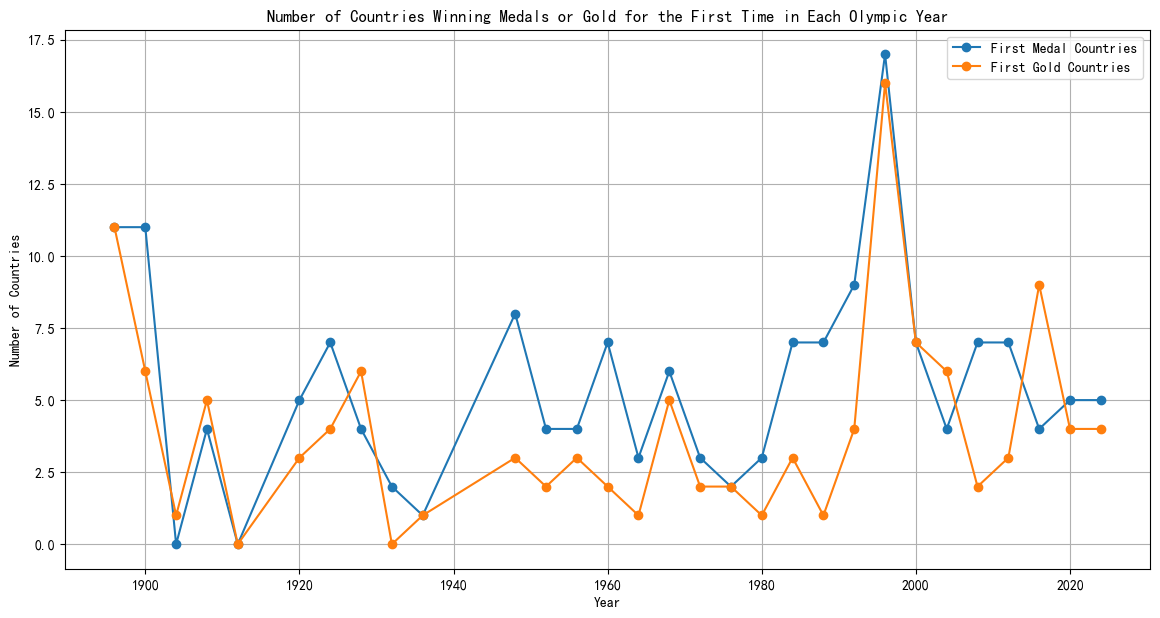

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
file_path = 'Generated\\first_medal_and_gold_countries.csv'
data = pd.read_csv(file_path)

# 绘制折线图
plt.figure(figsize=(14, 7))

# 绘制第一次获得奖牌的国家数
plt.plot(data['Year'], data['First Medal Countries'], label='First Medal Countries', marker='o')

# 绘制第一次获得金牌的国家数
plt.plot(data['Year'], data['First Gold Countries'], label='First Gold Countries', marker='o')

# 添加标题和标签
plt.title('Number of Countries Winning Medals or Gold for the First Time in Each Olympic Year')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.legend()

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

### 线性回归预测

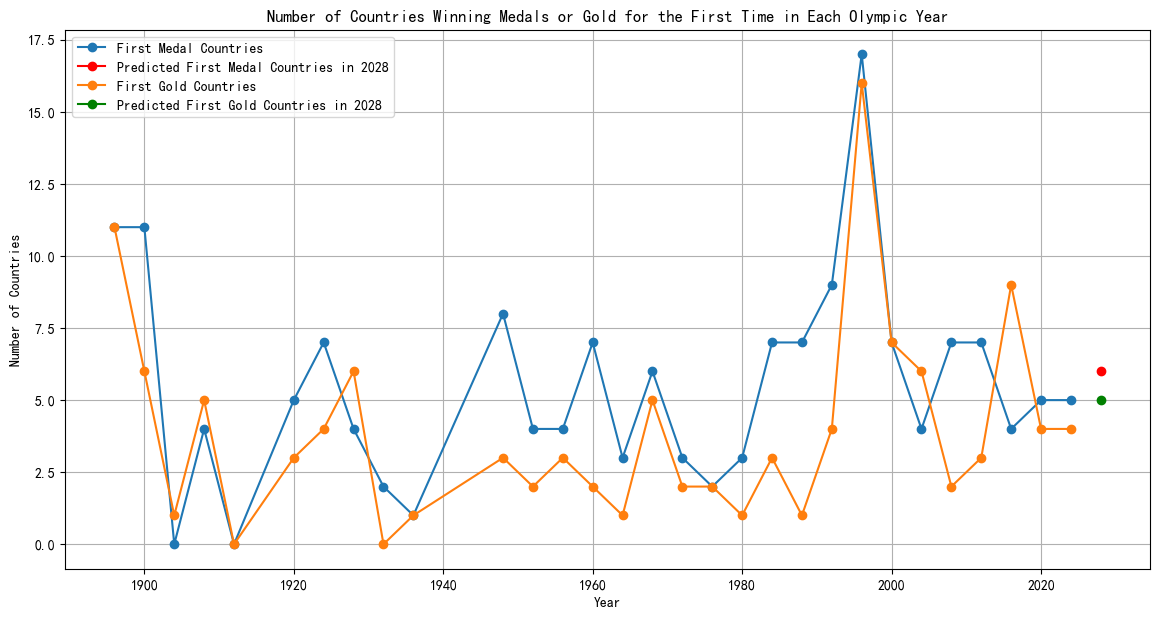

预测2028年首次获得奖牌的国家数量: 6
预测2028年首次获得金牌的国家数量: 5


In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 加载数据
file_path = 'Generated\\first_medal_and_gold_countries.csv'
data = pd.read_csv(file_path)

# 准备数据
years = data['Year'].values.reshape(-1, 1)
first_medal_countries = data['First Medal Countries'].values
first_gold_countries = data['First Gold Countries'].values

# 训练线性回归模型
model_medal = LinearRegression()
model_medal.fit(years, first_medal_countries)

model_gold = LinearRegression()
model_gold.fit(years, first_gold_countries)

# 预测2028年的值
year_2028 = np.array([2028]).reshape(-1, 1)
pre_medal_2028 = [round(model_medal.predict(year_2028)[0])]
pre_gold_2028 = [round(model_gold.predict(year_2028)[0])]

# 绘制折线图
plt.figure(figsize=(14, 7))

# 绘制第一次获得奖牌的国家数
plt.plot(data['Year'], data['First Medal Countries'], label='First Medal Countries', marker='o')
plt.plot([2028], pre_medal_2028, marker='o', color='red', label='Predicted First Medal Countries in 2028')

# 绘制第一次获得金牌的国家数
plt.plot(data['Year'], data['First Gold Countries'], label='First Gold Countries', marker='o')
plt.plot([2028], pre_gold_2028, marker='o', color='green', label='Predicted First Gold Countries in 2028')

# 添加标题和标签
plt.title('Number of Countries Winning Medals or Gold for the First Time in Each Olympic Year')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.legend()

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

# 输出预测结果
print(f"预测2028年首次获得奖牌的国家数量: {pre_medal_2028[0]}")
print(f"预测2028年首次获得金牌的国家数量: {pre_gold_2028[0]}")

- 分析效果

In [66]:
# 计算模型的拟合度
r2_medal = model_medal.score(years, first_medal_countries)
r2_gold = model_gold.score(years, first_gold_countries)

print(f"首次获得奖牌的国家数量模型的拟合度 (R^2): {r2_medal:.2f}")
print(f"首次获得金牌的国家数量模型的拟合度 (R^2): {r2_gold:.2f}")

首次获得奖牌的国家数量模型的拟合度 (R^2): 0.02
首次获得金牌的国家数量模型的拟合度 (R^2): 0.02


- 这说明有2%的可能完全准确
- 考虑到数目只为整数，可能性会更大

In [67]:
# 进行预测
pre_medal = model_medal.predict(years)
pre_gold = model_gold.predict(years)

# 四舍五入预测值
pre_medal_rounded = np.round(pre_medal)
pre_gold_rounded = np.round(pre_gold)

# 计算偏离
deviation_medal = np.abs(pre_medal_rounded - first_medal_countries)
deviation_gold = np.abs(pre_gold_rounded - first_gold_countries)

# 统计偏离超过1的次数
count_deviation_medal_over_1 = np.sum(deviation_medal > 1)
count_deviation_gold_over_1 = np.sum(deviation_gold > 1)

# 计算比例
proportion_deviation_medal_over_1 = count_deviation_medal_over_1 / len(years)
proportion_deviation_gold_over_1 = count_deviation_gold_over_1 / len(years)

# 输出比例
print(f"首次获得奖牌的国家数量预测偏离超过1的比例: {proportion_deviation_medal_over_1:.2f}")
print(f"首次获得金牌的国家数量预测偏离超过1的比例: {proportion_deviation_gold_over_1:.2f}")
print(f"首次获得奖牌的国家数量预测准确度: {(1-proportion_deviation_medal_over_1)*100:.2f}%")
print(f"首次获得金牌的国家数量预测准确度: {(1-proportion_deviation_gold_over_1)*100:.2f}%")

首次获得奖牌的国家数量预测偏离超过1的比例: 0.57
首次获得金牌的国家数量预测偏离超过1的比例: 0.67
首次获得奖牌的国家数量预测准确度: 43.33%
首次获得金牌的国家数量预测准确度: 33.33%


### 评估可能性

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.7110
Date:                  周二, 28 1月 2025   Prob (F-statistic):              0.406
Time:                        07:42:02   Log-Likelihood:                -79.692
No. Observations:                  30   AIC:                             163.4
Df Residuals:                      28   BIC:                             166.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.3475     32.992     -0.677      0.5

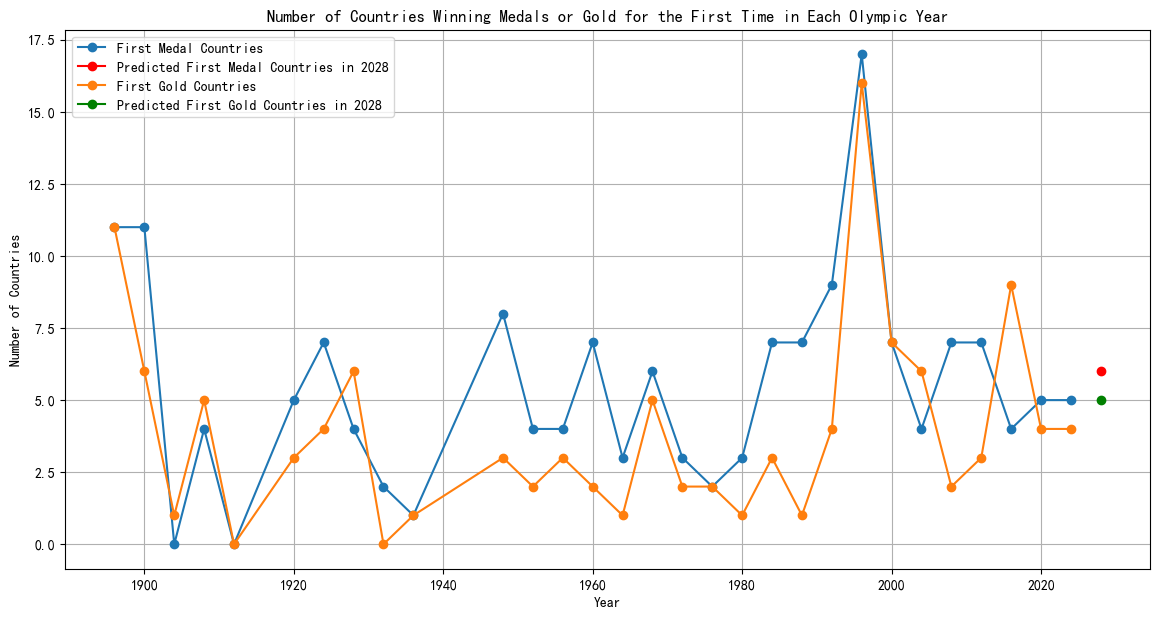

预测2028年首次获得奖牌的国家数量: 6
预测2028年首次获得金牌的国家数量: 5
预测2028年首次获得奖牌的国家数量的置信区间: [-182373.15, 91731.90]
预测2028年首次获得金牌的国家数量的置信区间: [-168204.18, 98528.84]


In [68]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 加载数据
file_path = 'Generated\\first_medal_and_gold_countries.csv'
data = pd.read_csv(file_path)

# 准备数据
years = data['Year'].values.reshape(-1, 1)
first_medal_countries = data['First Medal Countries'].values
first_gold_countries = data['First Gold Countries'].values

# 训练线性回归模型
model_medal = LinearRegression()
model_medal.fit(years, first_medal_countries)

model_gold = LinearRegression()
model_gold.fit(years, first_gold_countries)

# 预测2028年的值
year_2028 = np.array([[2028,1]])
pre_medal_2028 = round(model_medal.predict(year_2028.reshape(-1,1))[0])
pre_gold_2028 = round(model_gold.predict(year_2028.reshape(-1,1))[0])

# 使用statsmodels计算置信区间
X = sm.add_constant(years)  # 添加常数项
model_medal_sm = sm.OLS(first_medal_countries, X).fit()
model_gold_sm = sm.OLS(first_gold_countries, X).fit()

print(model_medal_sm.summary())
print(model_gold_sm.summary())

# 预测2028年的值及其置信区间
year_2028_sm = sm.add_constant(year_2028).reshape(-1,2)  # 添加常数项
pre_medal_2028_sm = model_medal_sm.get_prediction(year_2028_sm).summary_frame()
pre_gold_2028_sm = model_gold_sm.get_prediction(year_2028_sm).summary_frame()

# 绘制折线图
plt.figure(figsize=(14, 7))

# 绘制第一次获得奖牌的国家数
plt.plot(data['Year'], data['First Medal Countries'], label='First Medal Countries', marker='o')
plt.plot([2028], pre_medal_2028, marker='o', color='red', label='Predicted First Medal Countries in 2028')

# 绘制第一次获得金牌的国家数
plt.plot(data['Year'], data['First Gold Countries'], label='First Gold Countries', marker='o')
plt.plot([2028], pre_gold_2028, marker='o', color='green', label='Predicted First Gold Countries in 2028')

# 添加置信区间
#plt.fill_between([2028], pre_medal_2028_sm['mean_ci_lower'], pre_medal_2028_sm['mean_ci_upper'], color='red', alpha=0.2)
#plt.fill_between([2028], pre_gold_2028_sm['mean_ci_lower'], pre_gold_2028_sm['mean_ci_upper'], color='green', alpha=0.2)

# 添加标题和标签
plt.title('Number of Countries Winning Medals or Gold for the First Time in Each Olympic Year')
plt.xlabel('Year')
plt.ylabel('Number of Countries')
plt.legend()

# 显示网格
plt.grid(True)

# 显示图表
plt.show()

# 输出预测结果及其置信区间
print(f"预测2028年首次获得奖牌的国家数量: {pre_medal_2028}")
print(f"预测2028年首次获得金牌的国家数量: {pre_gold_2028}")
print(f"预测2028年首次获得奖牌的国家数量的置信区间: [{pre_medal_2028_sm['mean_ci_lower'][0]:.2f}, {pre_medal_2028_sm['mean_ci_upper'][0]:.2f}]")
print(f"预测2028年首次获得金牌的国家数量的置信区间: [{pre_gold_2028_sm['mean_ci_lower'][0]:.2f}, {pre_gold_2028_sm['mean_ci_upper'][0]:.2f}]")

## 第三问

- 您的模型还应考虑特定奥运会的赛事（数量和类型）。
- 探究赛事与各国所获奖牌数量之间的关系。
- 对于不同国家而言，哪些体育项目最为重要？原因何在？
- 主办国所选择的赛事如何影响比赛结果？

### 各国优势项目

#### 预处理

In [69]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('2025_Problem_C_Data\\summerOly_athletes.csv')

# 定义一个函数，将Medal列中的值转换为对应的奖牌类型
def medal_to_type(medal):
    if medal == 'Gold':
        return 'Gold'
    elif medal == 'Silver':
        return 'Silver'
    elif medal == 'Bronze':
        return 'Bronze'
    else:
        return 'No Medal'

# 应用函数转换Medal列
df['Medal_Type'] = df['Medal'].apply(medal_to_type)

# 按NOC和Sport分组，统计每种奖牌的数量
medal_counts = df[df['Medal_Type'] != 'No Medal'].groupby(['NOC', 'Sport', 'Medal_Type']).size().unstack(fill_value=0)

# 重置索引，以便将NOC和Sport作为列
medal_counts = medal_counts.reset_index()

# 填充缺失的奖牌类型列
medal_counts = medal_counts.fillna(0)

# 确保奖牌列是数值类型
medal_counts['Gold'] = medal_counts.get('Gold', 0).astype(int)
medal_counts['Silver'] = medal_counts.get('Silver', 0).astype(int)
medal_counts['Bronze'] = medal_counts.get('Bronze', 0).astype(int)

# 计算总奖牌数
medal_counts['Total'] = medal_counts[['Gold', 'Silver', 'Bronze']].sum(axis=1)

# 重新排列列的顺序
medal_counts = medal_counts[['NOC', 'Sport', 'Gold', 'Silver', 'Bronze', 'Total']]

# 保存结果到CSV文件
medal_counts.to_csv('Generated2\\medal_counts.csv', index=False)

# 显示结果
medal_counts.head()

Medal_Type,NOC,Sport,Gold,Silver,Bronze,Total
0,AFG,Taekwondo,0,0,2,2
1,AHO,Sailing,0,1,0,1
2,AIN,Rowing,0,1,0,1
3,AIN,Tennis,0,2,0,2
4,AIN,Trampoline Gymnastics,1,1,0,2


### 得出优势项目

In [70]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('Generated2\\medal_counts.csv')

# 定义一个函数，用于获取每个国家总奖牌榜和金牌榜前2的运动项目
def get_top_sports(group):
    #print(group)
    # 按总奖牌数降序排列
    total_sorted = group.sort_values(by='Total', ascending=False)
    # 按金牌数降序排列
    gold_sorted = group.sort_values(by='Gold', ascending=False)
    
    # 获取前2的运动项目
    total_top2 = total_sorted.head(2)[['Sport', 'Total']]
    gold_top2 = gold_sorted.head(2)[['Sport', 'Gold']]
    
    # 提取结果
    result = {
        'Gold1': gold_top2.iloc[0]['Sport'] if len(gold_top2) > 0 else None,
        'Gold2': gold_top2.iloc[1]['Sport'] if len(gold_top2) > 1 else None,
        'Total1': total_top2.iloc[0]['Sport'] if len(total_top2) > 0 else None,
        'Total2': total_top2.iloc[1]['Sport'] if len(total_top2) > 1 else None
    }

    #print(result)
    
    return pd.Series(result)

# 应用函数，获取每个国家的前2运动项目
results = df.groupby('NOC').apply(get_top_sports).reset_index()

# 保存到新的CSV文件
results.to_csv('Generated2\\top_sports.csv', index=False)

# 打印结果
print(results)

     NOC                  Gold1       Gold2      Total1                 Total2
0    AFG              Taekwondo        None   Taekwondo                   None
1    AHO                Sailing        None     Sailing                   None
2    AIN  Trampoline Gymnastics      Rowing      Tennis  Trampoline Gymnastics
3    ALB              Wrestling        None   Wrestling                   None
4    ALG              Athletics      Boxing   Athletics                 Boxing
..   ...                    ...         ...         ...                    ...
152  VIE               Shooting   Taekwondo    Shooting              Taekwondo
153  WIF              Athletics        None   Athletics                   None
154  YUG               Handball  Water Polo  Basketball             Water Polo
155  ZAM              Athletics      Boxing   Athletics                 Boxing
156  ZIM                 Hockey    Swimming      Hockey               Swimming

[157 rows x 5 columns]


C:\Users\Ziqi\AppData\Local\Temp\ipykernel_30472\3729593612.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('NOC').apply(get_top_sports).reset_index()


## 东道主效应

### 回归分析模型

+ 考虑金牌数对奖牌数贡献
+ 考虑项目数量增长对奖牌数贡献

In [71]:
# 导入必要的库
import pandas as pd
import statsmodels.api as sm
import re
from sklearn.preprocessing import StandardScaler

# 读取CSV文件
medal_counts = pd.read_csv('2025_Problem_C_Data\\summerOly_medal_counts.csv')
hosts = pd.read_csv('2025_Problem_C_Data\\summerOly_hosts.csv')
project_amount = pd.read_csv('Generated\\Project_amount.csv')

# 数据预处理
# 去除NOC列和Host列中的非英文字符
medal_counts['NOC'] = medal_counts['NOC'].apply(lambda x: re.sub(r'[^a-zA-Z]', '', x))
hosts['Host'] = hosts['Host'].apply(lambda x: re.sub(r'[^a-zA-Z]', '', x))

# 如果Host中的字符串包含NOC中的字符串，就将其替换为NOC的值
def replace_host(row):
    for noc in medal_counts['NOC']:
        if noc in row:
            return noc
    return row

hosts['Host'] = hosts['Host'].apply(replace_host)
hosts.loc[hosts['Host'] == 'LondonUnitedKingdom', 'Host'] = 'GreatBritain'

# 将medal_counts和hosts数据按Year列合并
merged_data = pd.merge(medal_counts, hosts, on='Year', how='left')

# 将merged_data和project_amount数据按Year列合并
merged_data = pd.merge(merged_data, project_amount, on='Year', how='left')

# 填充缺失值
merged_data['Host'] = merged_data['Host'].fillna('Not Host')
merged_data['Amount'] = merged_data['Amount'].fillna(merged_data['Amount'].mean())

# 创建东道主标识变量
merged_data['Is_Host'] = merged_data['NOC'] == merged_data['Host']

# 选择特征和目标变量
X = merged_data[['Gold', 'Is_Host', 'Amount']]
y = merged_data['Total']

# 数据标准化
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# 添加常数项
#X_scaled = sm.add_constant(X_scaled)
X = sm.add_constant(X)

# 构建回归模型
model = sm.OLS(y, X.astype(float)).fit()

# 输出模型结果
print(model.summary())

# 对每个国家分别进行回归分析
results = []
for noc in merged_data['NOC'].unique():
    country_data = merged_data[merged_data['NOC'] == noc]
    if len(country_data) > 1:  # 确保每个国家至少有两条数据
        X_country = country_data[['Gold', 'Is_Host', 'Amount']]
        y_country = country_data['Total']
        
        # 数据标准化
        #X_country_scaled = scaler.fit_transform(X_country)
        
        # 添加常数项
        #X_country_scaled = sm.add_constant(X_country_scaled)
        X_country = sm.add_constant(X_country)

        # 构建回归模型
        model_country = sm.OLS(y_country, X_country.astype(float)).fit()
        
        # 保存结果
        results.append({
            'NOC': noc,
            'Is_Host_Coef': model_country.params['Is_Host'],
            'Is_Host_PValue': model_country.pvalues['Is_Host']
        })

# 将结果转换为DataFrame
results_df = pd.DataFrame(results)

# 输出每个国家的东道主效应结果
print(results_df)

# 计算并输出Is_Host系数的均值
is_host_mean = results_df['Is_Host_Coef'].mean()
print(f"Is_Host系数的均值: {is_host_mean:.2f}")

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     7701.
Date:                  周二, 28 1月 2025   Prob (F-statistic):               0.00
Time:                        07:42:02   Log-Likelihood:                -4405.0
No. Observations:                1435   AIC:                             8818.
Df Residuals:                    1431   BIC:                             8839.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0739      0.447      4.636      0.0

- Is_Host系数均值明显为正，说明成为东道主对总奖牌数有正面促进作用。

## 伟大教练效应

### 预处理

In [72]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('2025_Problem_C_Data\\summerOly_athletes.csv')

# 将Medal列中的值转换为Gold, Silver, Bronze
df['Medal'] = df['Medal'].replace({'No medal': None, 'Gold': 'Gold', 'Silver': 'Silver', 'Bronze': 'Bronze'})

# 按NOC, Year, Sport分组，统计每种奖牌的数量
medal_counts = df.groupby(['NOC', 'Year', 'Sport'])['Medal'].value_counts().unstack(fill_value=0)

# 重置索引，将NOC, Year, Sport作为列
medal_counts = medal_counts.reset_index()

# 填充缺失的奖牌类型列
medal_counts = medal_counts.fillna(0)

# 计算Total列
medal_counts['Total'] = medal_counts['Gold'] + medal_counts['Silver'] + medal_counts['Bronze']

# 重新排列列的顺序
medal_counts = medal_counts[['NOC', 'Sport', 'Year', 'Gold', 'Silver', 'Bronze', 'Total']]

# 显示结果
print(medal_counts)
medal_counts.to_csv('Generated2\\sports_medal_counts.csv')

Medal  NOC      Sport  Year  Gold  Silver  Bronze  Total
0      AFG  Taekwondo  2008     0       0       1      1
1      AFG  Taekwondo  2012     0       0       1      1
2      AHO    Sailing  1988     0       1       0      1
3      AIN     Rowing  2024     0       1       0      1
4      AIN     Tennis  2024     0       2       0      2
...    ...        ...   ...   ...     ...     ...    ...
6740   ZAM  Athletics  1996     0       1       0      1
6741   ZAM  Athletics  2024     0       0       1      1
6742   ZIM     Hockey  1980    15       0       0     15
6743   ZIM   Swimming  2004     1       1       1      3
6744   ZIM   Swimming  2008     1       3       0      4

[6745 rows x 7 columns]


### LSTM + Transformer模型

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# 1. 数据准备
# 读取CSV文件
data = pd.read_csv('Generated2\\sports_medal_counts.csv')

# 2. 数据预处理
# 归一化处理
def preprocess_data(data, time_step=1):
    data = data.sort_values(by='Year')
    data.set_index('Year', inplace=True)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X, Y = create_dataset(data_scaled, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, Y, scaler

# 创建时间序列数据
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# 3. 构建LSTM + Transformer模型
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_model(time_step):
    input_shape = (time_step, 1)
    inputs = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(inputs)
    x = transformer_encoder(x, head_size=160, num_heads=4, ff_dim=4, dropout=0.25)
    x = LSTM(50)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')
    return model

# 4. 遍历所有国家和项目
results = []

for country in data['NOC'].unique():
    for sport in data[data['NOC'] == country]['Sport'].unique():
        project_data = data[(data['NOC'] == country) & (data['Sport'] == sport)][['Year', 'Total']]
        
        # 如果数据量太少，跳过
        if len(project_data) < 10:
            continue
        
        # 数据预处理
        X, Y, scaler = preprocess_data(project_data, time_step=5)
        
        # 训练模型
        model = build_model(time_step=5)
        model.fit(X, Y, epochs=100, batch_size=32, verbose=0)
        
        # 使用模型进行预测
        Y_pred = model.predict(X)
        
        # 反归一化
        Y_pred = scaler.inverse_transform(Y_pred)
        Y_true = scaler.inverse_transform(Y.reshape(-1, 1))
        
        # 计算异常分数
        anomaly_score = np.abs(Y_true - Y_pred)
        
        # 找出异常上升或下降的年份
        threshold = np.percentile(anomaly_score, 95)
        anomaly_indices = np.where(anomaly_score.flatten() > threshold)[0]
        
        # 调整索引以匹配原始数据
        anomaly_years = project_data.index[anomaly_indices + 5]
        
        # 区分异常上升和异常下降
        for year in anomaly_years:
            index = anomaly_indices[anomaly_years.get_loc(year)]
            if index - 5 < 0:
                continue  # 跳过索引超出范围的情况
            if Y_pred[index - 5] > Y_true[index - 5]:
                anomaly_type = 'Down'
            else:
                anomaly_type = 'Up'
            results.append((country, sport, year, anomaly_type))

# 5. 输出结果
results_df = pd.DataFrame(results, columns=['NOC', 'Sports', 'Time', 'Type'])
print(results_df)
result_df.to_csv('Result2\\exception_country.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [74]:
results_df.to_csv('Result2\\exception_country.csv')

+ 在诸如郎平、贝拉·卡罗利这样的伟大教练进出某国时，产生了明显的影响。